In [1]:
from one.api import ONE
from brainbox.singlecell import bin_spikes2D
from brainwidemap import (bwm_query, load_good_units, 
                          load_trials_and_mask, bwm_units)
from iblatlas.atlas import AllenAtlas
from iblatlas.regions import BrainRegions
import iblatlas
from iblatlas.plots import plot_swanson_vector 
from brainbox.io.one import SessionLoader

import sys
sys.path.append('Dropbox/scripts/IBL/')
#from granger import get_volume, get_centroids, get_res, get_structural, get_ari
#from state_space_bwm import get_cmap_bwm, pre_post
#from bwm_figs import variverb

from scipy import signal
import pandas as pd
import numpy as np

from collections import Counter
from sklearn.decomposition import PCA, FastICA
from sklearn.cluster import KMeans, SpectralClustering
from sklearn.manifold import TSNE
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram
from statsmodels.stats.multitest import multipletests
from sklearn.metrics import confusion_matrix
from sklearn.cluster import SpectralCoclustering, SpectralBiclustering
from sklearn.cluster import DBSCAN, OPTICS, Birch, MiniBatchKMeans
from numpy.linalg import norm
from scipy.stats import gaussian_kde, f_oneway, pearsonr, spearmanr, kruskal, linregress
from scipy.spatial import distance
from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform, cdist
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import SpectralEmbedding
from random import shuffle
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import KFold
from sknetwork.clustering import Louvain, Leiden, KCenters
from sknetwork.visualization import visualize_graph
from IPython.display import SVG
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score
from scipy import sparse
from scipy.stats import wasserstein_distance, wasserstein_distance_nd
import gc
from pathlib import Path
import random
from copy import deepcopy
import time, sys, math, string, os
from scipy.stats import spearmanr, zscore, combine_pvalues
import umap
from itertools import combinations, chain
from datetime import datetime
import scipy.ndimage as ndi
from rastermap import Rastermap
import scipy.cluster.hierarchy as sch
import plotly.graph_objects as go
import copy
from collections import defaultdict
#import hdbscan

from matplotlib.axis import Axis
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as patches
import seaborn as sns
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.colors import ListedColormap, LinearSegmentedColormap   
from matplotlib.gridspec import GridSpec   
import mpldatacursor
from matplotlib.lines import Line2D
from matplotlib.colors import to_rgba
from matplotlib.patches import Rectangle
from matplotlib.ticker import ScalarFormatter
from matplotlib.ticker import MaxNLocator
from matplotlib.pyplot import cm
from venny4py.venny4py import *
import networkx as nx
from termcolor import colored
import dataframe_image as dfi
from sklearn.metrics.pairwise import cosine_similarity
from scipy.stats import chi2
# from scipy.stats import norm
from scipy.cluster.hierarchy import fcluster
from collections import defaultdict

from PIL import Image

import warnings
warnings.filterwarnings("ignore")
#mpl.use('QtAgg')

# for vari plot
#_, b, lab_cols = labs()
plt.ion() 
 
np.set_printoptions(threshold=sys.maxsize)

plt.rcParams.update(plt.rcParamsDefault)
plt.ion()

f_size = 15  # font size

# canonical colors for left and right trial types
blue_left = [0.13850039, 0.41331206, 0.74052025]
red_right = [0.66080672, 0.21526712, 0.23069468]

T_BIN = 0.0125  # bin size [sec] for neural binning
sts = 0.002  # stride size in [sec] for overlapping bins
ntravis = 30  # #trajectories for vis, first 2 real, rest pseudo

# conversion divident to get bins in seconds 
# (taking strinding into account)
c_sec =  int(T_BIN // sts) / T_BIN


one = ONE(base_url='https://openalyx.internationalbrainlab.org',
          password='international', silent=True)

#base_url='https://openalyx.internationalbrainlab.org',
#          password='international', silent=True 
                   
br = BrainRegions()
#units_df = bwm_units(one)  # canonical set of cells


# save results here
pth_dmn = Path(one.cache_dir, 'dmn', 'res')
pth_dmn.mkdir(parents=True, exist_ok=True)

sigl = 0.05  # significance level (for stacking, plotting, fdr)


# order sensitive: must be tts__ = concat_PETHs(pid, get_tts=True).keys()
tts__ = ['inter_trial', 'blockL', 'blockR', 'block50', 'quiescence', 
         'stimLbLcL', 'stimLbRcL', 'stimLbRcR', 'stimLbLcR', 'stimRbLcL', 
         'stimRbRcL', 'stimRbRcR', 'stimRbLcR', 'motor_init', 'sLbLchoiceL', 
         'sLbRchoiceL', 'sLbRchoiceR', 'sLbLchoiceR', 'sRbLchoiceL', 'sRbRchoiceL', 
         'sRbRchoiceR', 'sRbLchoiceR', 'choiceL', 'choiceR',  'fback1', 'fback0']
#'fback0sRbL', 'fback0sLbR',


PETH_types_dict = {
    'concat': [item for item in tts__],
    'resting': ['inter_trial'],
    'quiescence': ['quiescence'],
    'pre-stim-prior': ['blockL', 'blockR'],
    'block50': ['block50'],
    'stim_surp_incon': ['stimLbRcL','stimRbLcR'],
    'stim_surp_con': ['stimLbLcL', 'stimRbRcR'],
    'stim_all': ['stimLbRcL','stimRbLcR','stimLbLcL', 'stimRbRcR'],
    'mistake': ['stimLbRcR', 'stimLbLcR', 'stimRbLcL', 'stimRbRcL',
                'sLbRchoiceR', 'sLbLchoiceR', 'sRbLchoiceL', 'sRbRchoiceL'],
    'motor_init': ['motor_init'],
    'movement': ['choiceL', 'choiceR'],
    'fback1': ['fback1'],
    'fback0': ['fback0']}      

phases_dict = {
    'concat': 'concat',
    'resting': 'resting',
    'quiescence': 'quiescence',
    'pre-stim-prior': 'pre-stim prior',
    'stim_surp_incon': 'stim surprise',
    'stim_surp_con': 'stim congruent',
    'mistake': 'mistake',
    'motor_init': 'motor init',
    'movement': 'movement',
    'fback1': 'fback correct',
    'fback0': 'fback incorrect'}      


data_lengths={'inter_trial': 72,
              'blockL': 144,
              'blockR': 144,
              'block50': 144,
              'quiescence': 144,
              'stimLbLcL': 96,
              'stimLbRcL': 96,
              'stimLbRcR': 96,
              'stimLbLcR': 96,
              'stimRbLcL': 96,
              'stimRbRcL': 96,
              'stimRbRcR': 96,
              'stimRbLcR': 96,
              'motor_init': 72,
              'sLbLchoiceL': 72,
              'sLbRchoiceL': 72,
              'sLbRchoiceR': 72,
              'sLbLchoiceR': 72,
              'sRbLchoiceL': 72,
              'sRbRchoiceL': 72,
              'sRbRchoiceR': 72,
              'sRbLchoiceR': 72,
              'choiceL': 72,
              'choiceR': 72,
              'fback1': 144,
              'fback0': 144
             }
     
peth_ila = [
    r"$\mathrm{rest}$",
    r"$\mathrm{L_b}$",
    r"$\mathrm{R_b}$",
    r"$\mathrm{50_b}$",
    r"$\mathrm{quies}$",
    r"$\mathrm{L_sL_cL_b, s}$",
    r"$\mathrm{L_sL_cR_b, s}$",
    r"$\mathrm{L_sR_cR_b, s}$",
    r"$\mathrm{L_sR_cL_b, s}$",
    r"$\mathrm{R_sL_cL_b, s}$",
    r"$\mathrm{R_sL_cR_b, s}$",
    r"$\mathrm{R_sR_cR_b, s}$",
    r"$\mathrm{R_sR_cL_b, s}$",
    r"$\mathrm{m}$",
    r"$\mathrm{L_sL_cL_b, m}$",
    r"$\mathrm{L_sL_cR_b, m}$",
    r"$\mathrm{L_sR_cR_b, m}$",
    r"$\mathrm{L_sR_cL_b, m}$",
    r"$\mathrm{R_sL_cL_b, m}$",
    r"$\mathrm{R_sL_cR_b, m}$",
    r"$\mathrm{R_sR_cR_b, m}$",
    r"$\mathrm{R_sR_cL_b, m}$",
    r"$\mathrm{L_{move}}$",
    r"$\mathrm{R_{move}}$",
    r"$\mathrm{feedbk1}$",
    r"$\mathrm{feedbk0}$"
]


peth_dict = dict(zip(tts__, peth_ila))


def get_name(brainregion):
    '''
    get verbose name for brain region acronym
    '''
    regid = br.id[np.argwhere(br.acronym == brainregion)][0, 0]
    return br.name[np.argwhere(br.id == regid)[0, 0]]

dmn_regs = ['ACAd', 'ACAv', 'PL', 'ILA', 'ORBl', 'ORBm', 
            'ORBvl', 'VISa', 'VISam', 'RSPagl','RSPd', 
            'RSPv', 'SSp-tr', 'SSp-ll', 'MOs']

cortical_regions = {
    "Prefrontal": [
        "FRP", "ACAd", "ACAv", "PL", "ILA",
        "ORBl", "ORBm", "ORBvl"
    ],
    "Lateral": [
        "AId", "AIv", "AIp", "GU", "VISc",
        "TEa", "PERI", "ECT"
    ],
    "Somatomotor": [
        "SSs", "SSp-bfd", "SSp-tr", "SSp-ll",
        "SSp-ul", "SSp-un", "SSp-n", "SSp-m",
        "MOp", "MOs"
    ],
    "Visual": [
        "VISal", "VISl", "VISp", "VISpl",
        "VISli", "VISpor", "VISrl"
    ],
    "Medial": [
        "VISa", "VISam", "VISpm",
        "RSPagl", "RSPd", "RSPv"
    ],
    "Auditory": [
        "AUDd", "AUDp", "AUDpo", "AUDv"
    ]
}

cortical_colors = {"Prefrontal": 'r', 
                   "Lateral": 'yellow',
                   "Somatomotor": 'orange',
                   "Visual": 'g',
                   "Medial": 'blue',
                   "Auditory": 'purple'
                  }


networks = {
    # 'concat_1': 'VISp',
    # 'concat_2': 'PRM',
    # 'quiescence_1': 'DP',
    'quiescence_2': 'GRN',
    # 'pre-stim-prior_1': 'VISp',
    # 'pre-stim-prior_2': 'MRN',
    # 'movement_1': 'MOs',
    'movement_2': 'VISp',
    'movement_3': 'CA1',
    # 'mistake_1': 'PRNr',
    # 'mistake_2': 'ORBvl',
    # 'mistake_3': 'SUB',
    'stim_surp_incon_1': 'VISp',
    'stim_surp_incon_2': 'GRN',
    'stim_surp_con_1': 'VAL',
    'stim_surp_con_2': 'IP',
    'stim_surp_con_3': 'VISp',
    'motor_init_1': 'VISp',
    'motor_init_2': 'CP',
    'motor_init_3': 'IP',
    'fback1_1': 'VISp',
    'fback1_2': 'GRN',
    'fback1_3': 'CA1',
    'fback0_1': 'CA1',
    'fback0_2': 'PRNr'
}

networks_full = {
    'concat_1': 'VISp',
    'concat_2': 'PRM',
    'quiescence_1': 'DP',
    'quiescence_2': 'GRN',
    'pre-stim-prior_1': 'VISp',
    'pre-stim-prior_2': 'MRN',
    'movement_1': 'MOs',
    'movement_2': 'VISp',
    'movement_3': 'CA1',
    'mistake_1': 'PRNr',
    'mistake_2': 'ORBvl',
    'mistake_3': 'SUB',
    'stim_surp_incon_1': 'VISp',
    'stim_surp_incon_2': 'GRN',
    'stim_surp_con_1': 'VAL',
    'stim_surp_con_2': 'IP',
    'stim_surp_con_3': 'VISp',
    'motor_init_1': 'VISp',
    'motor_init_2': 'CP',
    'motor_init_3': 'IP',
    'fback1_1': 'VISp',
    'fback1_2': 'GRN',
    'fback1_3': 'CA1',
    'fback0_1': 'CA1',
    'fback0_2': 'PRNr'
}

network_colors = {
    'concat_1': 'green',
    'concat_2': 'pink',
    'quiescence_1': 'green',
    'quiescence_2': 'pink',
    'pre-stim prior_1': 'green',
    'pre-stim prior_2': 'pink',
    'movement_1': 'pink',
    'movement_2': 'green',
    'movement_3': 'green',
    'mistake_1': 'pink',
    'mistake_2': 'green',
    'mistake_3': 'green',
    'stim surprise_1': 'green',
    'stim surprise_2': 'pink',
    'stim congruent_1': 'pink',
    'stim congruent_2': 'pink',
    'stim congruent_3': 'green',
    'motor init_1': 'green',
    'motor init_2': 'pink',
    'motor init_3': 'pink',
    'fback correct_1': 'green',
    'fback correct_2': 'pink',
    'fback correct_3': 'green',
    'fback incorrect_1': 'green',
    'fback incorrect_2': 'pink'
}

raster_types = {
    'stim_response': {'start': [6000], 'end': [6734]},
    'error': {'start': [7200, 10000, 20750, 34600], 
                       'end': [8400, 11000, 21250, 36000]},
    'integrator': {'start':[3700], 'end':[6000]},
    'stim_n_int': {'start':[3700], 'end': [6734]},
    'sequence': {'start': [13450, 21250], 'end': [20750, 34600]}, 
    'move_init': {'start': [840], 'end':[3700]},
    'movement': {'start':[43740], 'end':[44890]}
    
}


/Users/ariliu/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/one/alf/files.py:10: FutureWarning: `one.alf.files` will be removed in version 3.0. Use `one.alf.path` instead.
  warnings.warn(


In [115]:
# ghostscript
import subprocess
def ghostscript_compress_pdf(level='/printer'):

    '''
    Compress figs (inkscape pdfs)
    
    levels in [/screen, /ebook,  /printer]
    '''

    input_path = input("Please enter pdf input_path: ")
    print(f"Received input path: {input_path}")

    output_path = input("Please enter pdf output_path: ")
    print(f"Received output path: {output_path}")
    
    input_path = Path(input_path.strip("'\""))
    output_path = Path(output_path.strip("'\""))
    
    print('input_path', input_path)
    print('output_path', output_path)                 

    # Ghostscript command to compress PDF
    command = [
        'gs', '-sDEVICE=pdfwrite', '-dCompatibilityLevel=1.4',
        '-dAutoRotatePages=/None',
        f'-dPDFSETTINGS={level}', '-dNOPAUSE', '-dQUIET', '-dBATCH',
        f'-sOutputFile={output_path}', input_path
    ]

    # Execute the command
    try:
        subprocess.run(command, check=True)
        print(f"PDF successfully compressed and saved to {output_path}")
    except subprocess.CalledProcessError as e:
        print(f"An error occurred: {e}")

In [114]:
import re

# Given data
tts_old_ = ['stimLbLcL', 'stimLbRcL', 'stimLbRcR', 
            'stimLbLcR', 'stimRbLcL', 'stimRbRcL', 'stimRbRcR', 
            'stimRbLcR', 'sLbLchoiceL', 'sLbRchoiceL', 
            'sLbRchoiceR', 'sLbLchoiceR', 'sRbLchoiceL', 'sRbRchoiceL', 
            'sRbRchoiceR', 'sRbLchoiceR']
values = [1., 0.25, 0.125, 0.0625, 0.]

# Generate tts__ array
tts__ = [f'{tts}_{value}' for tts in tts_old_ for value in values]

# Dictionary to store matching elements
pairs = {}
block_pairs = []

# Loop through the generated array and store potential matches
for entry in tts__:
    match = re.match(r'(s.)(b.choice.?)_(\d+(\.\d+)?)', entry)
    if match:
        subject = match.group(1)  # Extract 'sX'
        choice_type = match.group(2)  # Extract 'bLchoiceX' or 'bRchoiceX'
        value = match.group(3)  # Extract the value as string

        key = (subject, value)  # Group by subject and value
        if key not in pairs:
            pairs[key] = {}

        pairs[key][choice_type] = entry  # Store the entry

# Extract valid pairs where both 'bLchoiceX' and 'bRchoiceX' exist
matched_pairs = [(pairs[k]['bLchoice' + k[0][-1]], pairs[k]['bRchoice' + k[0][-1]])
                 for k in pairs if 'bLchoice' + k[0][-1] in pairs[k] and 'bRchoice' + k[0][-1] in pairs[k]]

# Print results
for pair in matched_pairs:
    block_pairs.append(list(pair))
    # print(list(pair))

# Loop through the generated array and store potential matches
for entry in tts__:
    match = re.match(r'(stim.)(b.c.?)_(\d+(\.\d+)?)', entry)
    if match:
        subject = match.group(1)  # Extract 'sX'
        choice_type = match.group(2)  # Extract 'bLchoiceX' or 'bRchoiceX'
        value = match.group(3)  # Extract the value as string

        key = (subject, value)  # Group by subject and value
        if key not in pairs:
            pairs[key] = {}

        pairs[key][choice_type] = entry  # Store the entry

# Extract valid pairs where both 'bLchoiceX' and 'bRchoiceX' exist
matched_pairs = [(pairs[k]['bLc' + k[0][-1]], pairs[k]['bRc' + k[0][-1]])
                 for k in pairs if 'bLc' + k[0][-1] in pairs[k] and 'bRc' + k[0][-1] in pairs[k]]


# Print results
for pair in matched_pairs:
    block_pairs.append(list(pair))
    # print(list(pair))


In [2]:
from dmn_ari import *

In [118]:
ghostscript_compress_pdf()

Received input path: /Users/ariliu/Desktop/ibl-figures/dmn/SI_networks.pdf
Received output path: /Users/ariliu/Desktop/SI_networks.pdf
input_path /Users/ariliu/Desktop/ibl-figures/dmn/SI_networks.pdf
output_path /Users/ariliu/Desktop/SI_networks.pdf
PDF successfully compressed and saved to /Users/ariliu/Desktop/SI_networks.pdf


#### examine mistake trials - streaks

In [33]:
def fraction_wrong_streaks(trials: pd.DataFrame, min_streak_length: int = 3) -> float:
    """
    Calculate the fraction of wrong trials that occur in streaks longer than a specified length.

    Parameters:
    - trials (pd.DataFrame): DataFrame with 'feedbackType' 
        column (1 for correct, -1 for wrong).
    - min_streak_length (int): Minimum number of consecutive 
        wrong trials to qualify as a streak.

    Returns:
    - float: Fraction of wrong trials that are part of streaks 
    equal or longer than `min_streak_length`.
    """
    trials = trials.copy()
    trials['is_wrong'] = trials['feedbackType'] == -1
    trials['group'] = (trials['is_wrong'] != trials['is_wrong'].shift()).cumsum()

    wrong_streaks = trials[trials['is_wrong']].groupby('group').filter(
        lambda g: len(g) > (min_streak_length-1)
    )

    total_wrong = trials['is_wrong'].sum()
    if total_wrong == 0:
        return 0.0  # avoid division by zero
        
    # Group by streak and filter those that are:
    # - all wrong
    # - longer than min_streak_length
    # - have consistent choice (nunique == 1)
    same_choice_filter = (
        trials[trials['is_wrong']]
        .groupby('group')
        .filter(lambda g: len(g) > (min_streak_length-1) and g['choice'].nunique() == 1)
    )

    # wrong_streaks = wrong_streaks.drop(columns=['is_wrong', 'group'])
    # same_choice_filter = same_choice_filter.drop(columns=['is_wrong', 'group'])
    
    return {'wrong_streaks': wrong_streaks, 
            'same_choice_wrong_streaks': same_choice_filter, 
            'len_wrong_streak': len(wrong_streaks),
            'len_samec_wrong_streak': len(same_choice_filter),
            'total_wrong': total_wrong
           }

def get_all_session_wrong_streaks(min_streak_length=3):

    df = bwm_query(one)
    eids_plus = df[['eid', 'probe_name', 'pid']].values
    
    len_wrong_streak, len_samec_wrong_streak, total_wrong = [], [], []
    for i in eids_plus:
        eid, probe, pid = i
        trials, mask = load_trials_and_mask(one, eid,
            saturation_intervals=['saturation_stim_plus04',
                                  'saturation_feedback_plus04',
                                  'saturation_move_minus02',
                                  'saturation_stim_minus04_minus01',
                                  'saturation_stim_plus06',
                                  'saturation_stim_minus06_plus06'])
    
        results = fraction_wrong_streaks(trials, min_streak_length)
        len_wrong_streak.append(results['len_wrong_streak'])
        total_wrong.append(results['total_wrong'])
        len_samec_wrong_streak.append(results['len_samec_wrong_streak'])

    fraction_wrong_streak = sum(len_wrong_streak)/sum(total_wrong)
    fraction_samec_wrong_streak = sum(len_samec_wrong_streak)/sum(total_wrong)
    results_all = {'fraction_wrong_streak': fraction_wrong_streak,
                   'fraction_samec_wrong_streak': fraction_samec_wrong_streak,
                   'total_wrong': total_wrong,
                   'len_wrong_streak': len_wrong_streak,
                   'len_samec_wrong_streak': len_samec_wrong_streak               
                  }
    
    np.save(Path(pth_dmn, f'wrong_streak_min{min_streak_length}.npy'), 
            results_all, allow_pickle=True)

### decoding time from seq/integrator cells

In [ ]:
from dmn_ari import sum_for_key

skip_n_bins = 0
feat = 'concat_z'
isort = r1['isort']
trial_types = ['stimLbLcL', 'stimLbRcL', 'stimRbRcR', 'stimRbLcR']
plot_configs = [
    {
        'label': 'error/sequence',
        'raster_type': 'sequence'
    },
    {
        'label': 'stim response + integrator',
        'raster_type': 'stim_n_int'
    }
]

# Prepare figure
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6), sharex=True)

# Plot 1: Decoding MSE
x_mse = np.linspace(0, 0.20, len(results_seq['group_mse_scores'][skip_n_bins:])) 
ax1.plot(x_mse, results_seq['group_mse_scores'][skip_n_bins:], label='seq')
ax1.plot(x_mse, results_stint['group_mse_scores'][skip_n_bins:], label='stim-int')
ax1.set_ylabel('MSE', fontsize=16)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.set_facecolor('none')
ax1.legend(frameon=False)

# Plot 2: Avg PETH
for config in plot_configs:
    raster_type = config['raster_type']
    start = raster_types[raster_type]['start'][0]
    end = raster_types[raster_type]['end'][0]
    sorted_data = r1[feat][isort][start:end]

    # Average over trials
    trial_means = []
    for trial_type in trial_types:
        start_time = sum_for_key(data_lengths, trial_type)
        end_time = sum_for_key(data_lengths, trial_type, after=True)
        trial_means.append(np.mean(sorted_data[:, start_time:end_time], axis=0))

    data = np.mean(trial_means, axis=0)
    x_peth = np.linspace(0, 0.20, len(data))
    ax2.plot(x_peth, data, label=config['label'])

ax2.set_xlabel('Time from stim onset (s)', fontsize=16)
ax2.set_ylabel('Avg PETH (z-scored)', fontsize=16)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.set_facecolor('none')
ax2.legend(frameon=False)

# Save combined figure
plt.tight_layout()
plt.savefig(Path(pth_dmn.parent, 'figs', 'combined_decoding_mse_peth.pdf'), 
            transparent=True, dpi=200)


In [13]:
control='ver0'
r, r1, norm_, norm1_ = get_cross_val_rastermap(control=control, 
                                               mapping='Beryl', 
                                               zscore=True)

2025-07-11 16:13:51,448 [INFO] normalizing data across axis=1
2025-07-11 16:13:52,807 [INFO] projecting out mean along axis=0
2025-07-11 16:13:53,997 [INFO] data normalized, 2.64sec
2025-07-11 16:13:53,998 [INFO] sorting activity: 50172 valid samples by 2496 timepoints
2025-07-11 16:14:06,212 [INFO] n_PCs = 200 computed, 14.86sec
2025-07-11 16:14:15,357 [INFO] 100 clusters computed, time 24.00sec
2025-07-11 16:14:29,113 [INFO] clusters sorted, time 37.76sec
2025-07-11 16:14:30,046 [INFO] clusters upsampled, time 38.69sec
2025-07-11 16:14:33,233 [INFO] rastermap complete, time 41.88sec


In [ ]:
isort = r1['isort']
trial_types = ['stimLbLcL', 'stimLbRcL', 'stimRbRcR', 'stimRbLcR']
# trial_types = ['sLbLchoiceL', 'sLbRchoiceL', 'sRbRchoiceR', 'sRbLchoiceR']
for raster_type in ['stim_response', 'integrator', 'move_init', 'movement']:
    start = raster_types[raster_type]['start'][0]
    end = raster_types[raster_type]['end'][0]
    sorted_data = r1['concat_z'][isort][start:end]

    # Average over trials
    trial_means = []
    for trial_type in trial_types:
        start_time = sum_for_key(data_lengths, trial_type)
        end_time = sum_for_key(data_lengths, trial_type, after=True)
        trial_means.append(np.mean(sorted_data[:, start_time:end_time], axis=0))

    data = np.mean(trial_means, axis=0)
    x_peth = np.linspace(0, 0.20, len(data))
    plt.plot(x_peth, data, label=raster_type)
plt.legend()
plt.show()

Train MSE: 0.000033, Train R²: 0.9905
Test MSE: 0.000121, Test R²: 0.9642
Train MSE: 0.000232, Train R²: 0.9320
Test MSE: 0.000265, Test R²: 0.9216


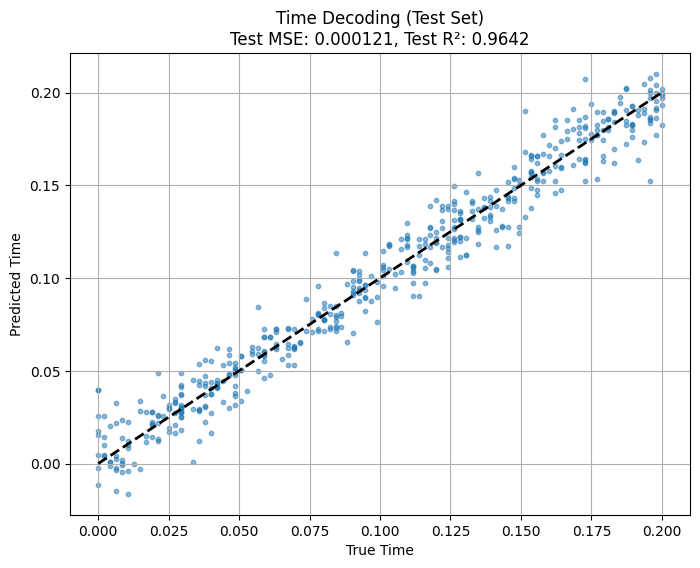

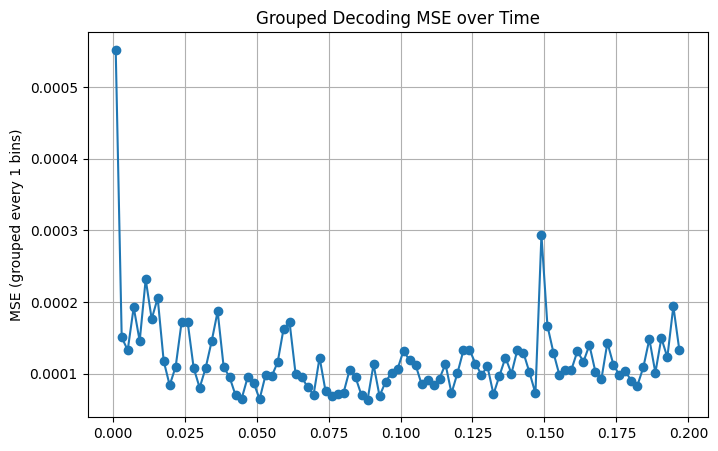

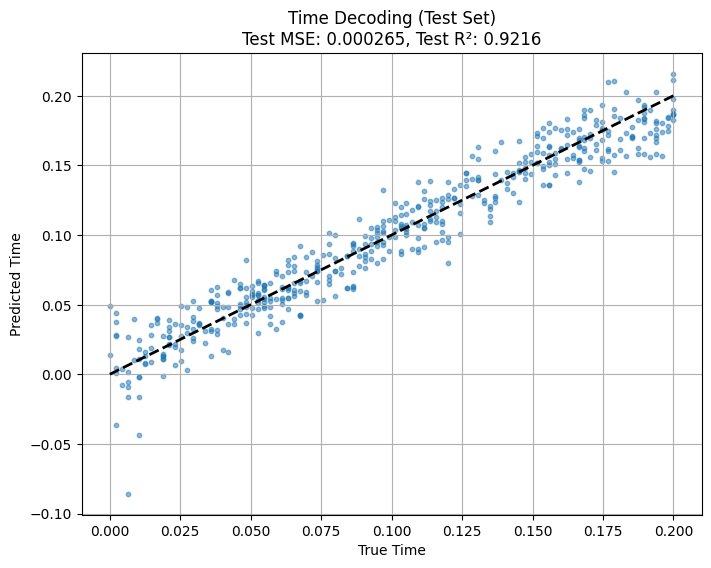

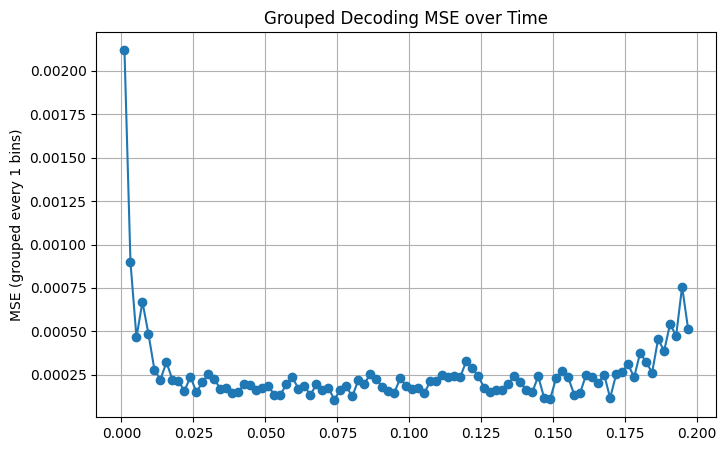

In [15]:
uuids_included, pids_included, cell_raster_type = get_uuids_raster_types(
    cell_types=['sequence', 
                'integrator', 
                'stim_n_int'])

seq_uuid = cell_raster_type['sequence']
int_uuid = cell_raster_type['integrator']
stint_uuid = cell_raster_type['stim_n_int']

seq_peth, stint_peth = get_decoding_data_by_type(seq_uuid, stint_uuid)

run_pca=False
# n_pcs = 10
random_state=99
ridge_alpha=1
group_n_bins=1
skip_n_bins=0

results_seq = decode_time_from_neural_data(seq_peth['all'], 
                                     'seq',
                                     run_pca=run_pca,
                                     alpha=ridge_alpha,
                                     n_pcs=2500, 
                                     random_state=random_state,
                                     group_n_bins=group_n_bins,
                                     skip_n_bins=skip_n_bins)
results_stint = decode_time_from_neural_data(stint_peth['all'], 
                                             'stint',
                                             run_pca=run_pca,
                                             alpha=ridge_alpha,
                                             n_pcs=700, 
                                             random_state=random_state, 
                                             group_n_bins=group_n_bins,
                                             skip_n_bins=skip_n_bins)

In [ ]:
# Unify number of cells in stint & seq groups
n_subsets = 4

# Slice `seq_uuid` into four roughly equal-length subsets
subset_size = len(seq_uuid) // n_subsets
subsets = [seq_uuid[i * subset_size: (i + 1) * subset_size] for i in range(n_subsets)]

# Handle the remainder if `len(seq_uuid)` isn't perfectly divisible by 4
if len(seq_uuid) % n_subsets != 0:
    subsets[-1] = np.concatenate([subsets[-1], seq_uuid[n_subsets * subset_size:]])

n_iterations = 10
for _ in range(n_iterations):
    # Randomly sample entries from each subset
    samples = []
    for subset in subsets:
        sample_size = len(stint_uuid) // n_subsets  # approximately same number of entries
        samples.append(np.random.choice(subset, sample_size, replace=False))
    
    seq_uuid = np.concatenate(samples)
    np.random.shuffle(seq_uuid)

    seq_peth, stint_peth = get_decoding_data_by_type(seq_uuid, stint_uuid)
    
    run_pca=False
    results_seq = decode_time_from_neural_data(seq_peth['all'], run_pca=run_pca)
    
results_stint = decode_time_from_neural_data(stint_peth['all'], run_pca=run_pca)

In [10]:
# randomly create a dataset as control
size=stint_peth['all'].shape
x = np.random.randint(0, 10, size=size)

In [ ]:
results = decode_time_from_neural_data(x, 
                                     alpha=ridge_alpha,
                                     n_pcs=100, 
                                     random_state=random_state,
                                     group_n_bins=5)


In [7]:
def get_decoding_data_by_type(seq_uuid, stint_uuid):

    decoding_data = np.load(Path(pth_dmn, f'decoding_data.npy'), allow_pickle=True).flat[0]
    
    seq_peth, int_peth, stint_peth, tls = {}, {}, {}, {}
    trial_names = ['stimLbLcL', 'stimLbRcL', 'stimRbRcR', 'stimRbLcR']
    for trial_name in trial_names:
        seq_peth[trial_name]=[]
        # int_peth[trial_name]=[]
        stint_peth[trial_name]=[]
        tls[trial_name]=[]
    
    for probe in decoding_data:
        # remove sessions with less than 20 trials for any trial type
        if min(decoding_data[probe]['tls'].values()) < 20:
            continue
        # concordant trial types should contain at least 80 trials
        elif decoding_data[probe]['tls']['stimLbLcL'] < 80:
            continue
        elif decoding_data[probe]['tls']['stimRbRcR'] < 80:
            continue
    
        seq_indices = [uuid in seq_uuid for uuid in decoding_data[probe]['uuids']]
        # int_indices = [uuid in int_uuid for uuid in decoding_data[probe]['uuids']]
        stint_indices = [uuid in stint_uuid for uuid in decoding_data[probe]['uuids']]
        
        for i in range(len(decoding_data[probe]['trial_names'])):
            trial_name = decoding_data[probe]['trial_names'][i]
            tls[trial_name].append(decoding_data[probe]['tls'][trial_name])
            seq_peth[trial_name].append(decoding_data[probe]['ws'][i][:,seq_indices])
            # int_peth[trial_name].append(decoding_data[probe]['ws'][i][:,int_indices])
            stint_peth[trial_name].append(decoding_data[probe]['ws'][i][:,stint_indices])
    
    seq_peth['all'], int_peth['all'], stint_peth['all'] = [], [], []
    for trial_name in trial_names:
        # unify number of trials for cells/sessions
        num_tr = min(tls[trial_name])
        seq_peth[trial_name] = [peth[:num_tr] for peth in seq_peth[trial_name]]
        # int_peth[trial_name] = [peth[:num_tr] for peth in int_peth[trial_name]]
        stint_peth[trial_name] = [peth[:num_tr] for peth in stint_peth[trial_name]]
        
        seq_peth[trial_name]=np.concatenate(seq_peth[trial_name], axis=1)
        # int_peth[trial_name]=np.concatenate(int_peth[trial_name], axis=1)
        stint_peth[trial_name]=np.concatenate(stint_peth[trial_name], axis=1)
        seq_peth['all'].append(seq_peth[trial_name])
        # int_peth['all'].append(int_peth[trial_name])
        stint_peth['all'].append(stint_peth[trial_name])
    
    seq_peth['all'] = np.concatenate(seq_peth['all'])
    # int_peth['all'] = np.concatenate(int_peth['all'])
    stint_peth['all'] = np.concatenate(stint_peth['all'])

    return seq_peth, stint_peth #int_peth

In [8]:
def get_uuids_raster_types(cell_types=['stim_res', 'integrator', 'move_init', 'movement']):
    # get uuids for cell types of interest (defined from rastermap)
    
    r1 = np.load(Path(pth_dmn,'cross_val_test.npy'), allow_pickle=True).flat[0]
    raster_types = {
        'stim_res': {'start': [6000], 'end': [6734]},
        'integrator': {'start':[3700], 'end':[6000]},
        'stim_n_int': {'start':[3700], 'end':[6734]},
        'move_init': {'start': [840], 'end':[3700]},
        'movement': {'start':[43740], 'end':[44890]}, 
        'sequence': {'start': [13450, 21250], 'end': [20750, 34600]}
    }
    
    uuids_included, pids_included, cell_raster_type = [], [], {}
    
    for raster_type in cell_types:
        start = raster_types[raster_type]['start']
        end = raster_types[raster_type]['end']
        isort = r1['isort']
        cell_raster_type[raster_type]=[]
        for i in range(len(start)):
            raster_type_ids = r1['uuids'][isort][start[i]:end[i]]
            pids = r1['pid'][isort][start[i]:end[i]]
            uuids_included.append(raster_type_ids)
            pids_included.append(pids)
            # cell_raster_type.append(np.repeat(raster_type, len(raster_type_ids)))
            cell_raster_type[raster_type].append(raster_type_ids)
        cell_raster_type[raster_type]=np.concatenate(cell_raster_type[raster_type])
        
    uuids_included=np.concatenate(uuids_included)
    pids_included=np.concatenate(pids_included)
    pids_included=list(set(pids_included))
    
    return uuids_included, pids_included, cell_raster_type

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score

def decode_time_from_neural_data(
    neural_data,
    name,
    time_bin_range=(0, 0.20),
    n_pcs=10,
    alpha=1.0,
    test_size=0.2,
    random_state=42,
    verbose=True,
    plot_results=True,
    run_pca=True,
    n_plot_samples=500,
    group_n_bins=1,
    skip_n_bins=2
):

    """ Decode time from neural data using optional PCA + Ridge Regression. """
    n_trials, n_cells, n_time_bins = neural_data.shape

    # --- Prepare X and y ---
    X = neural_data.transpose(0, 2, 1).reshape(-1, n_cells)  # (n_trials * n_time_bins, n_cells)
    time_bins = np.linspace(time_bin_range[0], time_bin_range[1], n_time_bins)
    y = np.tile(time_bins, n_trials)  # (n_trials * n_time_bins,)

    # --- Train/test split ---
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state
    )

    # --- Normalize (z-scoring) ---
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # --- PCA (optional) ---
    if run_pca:
        pca = PCA(n_components=n_pcs, random_state=random_state)
        X_train_pca = pca.fit_transform(X_train_scaled)
        X_test_pca = pca.transform(X_test_scaled)
    else:
        pca = None
        X_train_pca = X_train_scaled
        X_test_pca = X_test_scaled

    # --- Ridge regression ---
    model = Ridge(alpha=alpha, random_state=random_state)
    model.fit(X_train_pca, y_train)

    # --- Predict ---
    y_train_pred = model.predict(X_train_pca)
    y_test_pred = model.predict(X_test_pca)

    # --- Evaluation ---
    train_mse = mean_squared_error(y_train, y_train_pred)
    test_mse = mean_squared_error(y_test, y_test_pred)
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)

    # --- Evaluation per group of bins (skip bin 0) ---
    bin_edges = np.linspace(time_bin_range[0], time_bin_range[1], n_time_bins+1)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

    group_mse_scores = []
    group_centers = []

    # Start grouping after skipping some bins
    valid_start = skip_n_bins
    start_idxs = np.arange(valid_start, n_time_bins, group_n_bins)

    for start_idx in start_idxs:
        end_idx = min(start_idx + group_n_bins, n_time_bins)
        group_mask = (y_test >= bin_edges[start_idx]) & (y_test < bin_edges[end_idx])

        if np.sum(group_mask) > 1:
            mse_group = mean_squared_error(y_test[group_mask], y_test_pred[group_mask])
            group_mse_scores.append(mse_group)
        else:
            group_mse_scores.append(np.nan)

        group_centers.append(np.mean(bin_centers[start_idx:end_idx]))

    group_mse_scores = np.array(group_mse_scores)
    group_centers = np.array(group_centers)

    if verbose:
        print(f"Train MSE: {train_mse:.6f}, Train R²: {train_r2:.4f}")
        print(f"Test MSE: {test_mse:.6f}, Test R²: {test_r2:.4f}")
        if run_pca:
            print(f"Sum of variance explained by {n_pcs} PCs: {np.sum(pca.explained_variance_ratio_):.4f}")

    # --- Plotting ---
    if plot_results:
        idx = np.random.choice(len(y_test), size=min(n_plot_samples, len(y_test)), replace=False)
        plt.figure(figsize=(8, 6))
        plt.scatter(y_test[idx], y_test_pred[idx], alpha=0.5, s=10)
        plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
        # tick_locs = np.linspace(0, len(y_test) - 1, 6)  # 6 ticks (e.g., every ~30 ms)
        # tick_labels = np.linspace(0, 0.15, 6)
        # plt.xticks(tick_locs, [f"{t:.2f}" for t in tick_labels])
        plt.xlabel("True Time")
        plt.ylabel("Predicted Time")
        plt.title(f"Time Decoding (Test Set)\nTest MSE: {test_mse:.6f}, Test R²: {test_r2:.4f}")
        plt.grid(True)
        plt.savefig(Path(pth_dmn.parent, 'figs', f'decoding_result_{name}.pdf'), dpi=200)

        plt.figure(figsize=(8, 5))
        plt.plot(group_centers, group_mse_scores, marker='o')
        # tick_locs = np.linspace(0, len(y_test) - 1, 6)  # 6 ticks (e.g., every ~30 ms)
        # tick_labels = np.linspace(0, 0.15, 6)
        # plt.xticks(tick_locs, [f"{t:.2f}" for t in tick_labels])
        plt.ylabel(f'MSE (grouped every {group_n_bins} bins)')
        plt.title('Grouped Decoding MSE over Time')
        plt.grid(True)
        plt.savefig(Path(pth_dmn.parent, 'figs', f'decoding_mse_{name}.pdf'), dpi=200)

    return {
        "model": model,
        "pca": pca,
        "scaler": scaler,
        "train_mse": train_mse,
        "test_mse": test_mse,
        "train_r2": train_r2,
        "test_r2": test_r2,
        "group_mse_scores": group_mse_scores,
        "y_test": y_test,
        "y_test_pred": y_test_pred,
    }
    

### examine block effects on cell types from rastermap

In [144]:
block_pairs = [['sLbLchoiceL_1.0', 'sLbRchoiceL_1.0'],
 ['sLbLchoiceL_0.25', 'sLbRchoiceL_0.25'],
 ['sLbLchoiceL_0.125', 'sLbRchoiceL_0.125'],
 ['sLbLchoiceL_0.0625', 'sLbRchoiceL_0.0625'],
 ['sLbLchoiceL_0.0', 'sLbRchoiceL_0.0'],
 ['sRbLchoiceR_1.0', 'sRbRchoiceR_1.0'],
 ['sRbLchoiceR_0.25', 'sRbRchoiceR_0.25'],
 ['sRbLchoiceR_0.125', 'sRbRchoiceR_0.125'],
 ['sRbLchoiceR_0.0625', 'sRbRchoiceR_0.0625'],
 ['sRbLchoiceR_0.0', 'sRbRchoiceR_0.0'],
 ['stimLbLcL_1.0', 'stimLbRcL_1.0'],
 ['stimLbLcL_0.25', 'stimLbRcL_0.25'],
 ['stimLbLcL_0.125', 'stimLbRcL_0.125'],
 ['stimLbLcL_0.0625', 'stimLbRcL_0.0625'],
 ['stimLbLcL_0.0', 'stimLbRcL_0.0'],
 ['stimRbLcR_1.0', 'stimRbRcR_1.0'],
 ['stimRbLcR_0.25', 'stimRbRcR_0.25'],
 ['stimRbLcR_0.125', 'stimRbRcR_0.125'],
 ['stimRbLcR_0.0625', 'stimRbRcR_0.0625'],
 ['stimRbLcR_0.0', 'stimRbRcR_0.0']]

stim_pairs = [
 ['stimLbLcL', 'stimRbLcL'],
 ['stimLbRcL', 'stimRbRcL'],
 ['stimLbLcR', 'stimRbLcR'],
 ['stimLbRcR', 'stimRbRcR'],
 ['sLbLchoiceL', 'sRbLchoiceL'],
 ['sLbRchoiceL', 'sRbRchoiceL'],
 ['sLbRchoiceR', 'sRbRchoiceR'],
 ['sLbLchoiceR', 'sRbLchoiceR'],
]

choice_pairs = [
 ['stimLbLcL', 'stimLbLcR'],
 ['stimLbRcL', 'stimLbRcR'],
 ['stimRbLcL', 'stimRbLcR'],
 ['stimRbRcL', 'stimRbRcR'],
 ['sLbLchoiceL', 'sLbLchoiceR'],
 ['sLbRchoiceL', 'sLbRchoiceR'],
 ['sRbRchoiceL', 'sRbRchoiceR'],
 ['sRbLchoiceL', 'sRbLchoiceR']
]

In [145]:
def plot_averaged_distances_comparison(comparison_pairs, raster_type1='integrator', raster_type2='move_init',
                                       vers='concat_by_contrast_act'):
    """
    Plot averaged distance traces for two raster types overlaid in each panel.
    Left: stim-aligned trial types. Right: choice-aligned.
    """
    raster_types = [raster_type1, raster_type2]
    colors = {raster_type1: 'gold', raster_type2: 'tomato'}

    grouped_by_type = {'stim': {}, 'choice': {}}

    for rt in raster_types:
        d = np.load(Path(pth_dmn, f'{vers}_normFalse_shuffleTrue_{rt}.npy'),
                    allow_pickle=True).flat[0]
        for comparison in comparison_pairs:
            tt1 = '_'.join(comparison[0].split('_')[:-1])
            tt2 = '_'.join(comparison[1].split('_')[:-1])
            key = (tt1, tt2)
            if 'stim' in tt1:
                group = 'stim'
            elif 'choice' in tt1:
                group = 'choice'
            else:
                continue
            dist = d['distance'][f'{comparison[0]}_{comparison[1]}']
            dist = (dist / d['ids'].shape) ** 0.5
            grouped_by_type[group].setdefault(rt, []).append(dist)

    fig, axs = plt.subplots(1, 2, figsize=(5, 3), dpi=150, sharey=True)
    time_configs = {
        'stim': np.linspace(0, 0.20, grouped_by_type['stim'][raster_type1][0].shape[-1]),
        'choice': np.linspace(-0.15, 0, grouped_by_type['choice'][raster_type1][0].shape[-1])
    }
    tick_configs = {
        'stim': [0, 0.04, 0.08, 0.12],
        'choice': [0, -0.04, -0.08, -0.12]
    }

    for i, trial_type in enumerate(['stim', 'choice']):
        ax = axs[i]
        for rt in raster_types:
            if rt not in grouped_by_type[trial_type]:
                continue
            traces = np.stack(grouped_by_type[trial_type][rt])
            mean_trace = np.mean(traces, axis=0)
            t = time_configs[trial_type]
            if trial_type == 'stim':
                valid = t <= 0.15
                t = t[valid]
                mean_trace = mean_trace[:len(t)]
            ax.plot(t, mean_trace, label=rt, linewidth=2, color=colors[rt])

        # ax.set_title(f'{trial_type.title()}-aligned', fontsize=11)
        ax.set_xlabel('Time (s)')
        ax.set_xticks(tick_configs[trial_type])
        ax.set_xlim([t[0] - 0.01, t[-1]])
        ax.set_facecolor('none')
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.tick_params(axis='both', labelsize=10)

    # axs[0].set_ylabel('Distance')
    # axs[1].legend(frameon=False, fontsize=9)
    # fig.suptitle(f'Overlayed Avg Distance: {raster_type1} vs {raster_type2}', fontsize=12)
    fig.tight_layout()
    fig.savefig(Path(one.cache_dir, 'dmn', 'figs', f'{raster_type1}_vs_{raster_type2}_overlay.pdf'),
                dpi=100, transparent=True, bbox_inches='tight')


In [ ]:
plot_averaged_distances_comparison(block_pairs)

In [73]:
def plot_averaged_distances(block_pairs, raster_type, ptype='mean'):
    d = np.load(Path(pth_dmn, f'concat_by_contrast_normFalse_shuffleTrue_{raster_type}.npy'),
                allow_pickle=True).flat[0]

    grouped_distances = defaultdict(list)
    grouped_distance_controls = defaultdict(list)

    for comparison in block_pairs:
        trial_type1 = '_'.join(comparison[0].split('_')[:-1])
        trial_type2 = '_'.join(comparison[1].split('_')[:-1])
        trial_type_pair = (trial_type1, trial_type2)

        distance = d['distance'][f'{comparison[0]}_{comparison[1]}']
        distance = (distance / d['ids'].shape) ** 0.5
        distance_controls = d['distance_controls'][f'{comparison[0]}_{comparison[1]}']
        distance_controls = (distance_controls / d['ids'].shape) ** 0.5

        grouped_distances[trial_type_pair].append(distance)
        grouped_distance_controls[trial_type_pair].append(distance_controls)

    for trial_type_pair, distances_list in grouped_distances.items():
        mean_distance = np.mean(np.stack(distances_list), axis=0)
        stacked_controls = np.mean(np.stack(grouped_distance_controls[trial_type_pair]), 
                                   axis=0)  # shape: [n_controls, time]

        distances = np.concatenate([mean_distance[None, :], stacked_controls], axis=0)
        p_per_time = np.mean(distances >= distances[0], axis=0)

        if ptype == 'amp':
            amp = np.max(distances, axis=1) - np.min(distances, axis=1)
            p_value = np.mean(amp >= amp[0])
        elif ptype == 'mean':
            mean_vals = np.mean(distances, axis=1)
            p_value = np.mean(mean_vals >= mean_vals[0])
        else:
            print('Invalid ptype')
            return

        x_full = (np.linspace(0, 0.15, len(mean_distance)) if 'stim' in trial_type_pair[0]
                  else np.linspace(-0.15, 0, len(mean_distance)))

        x_plot = x_full
        mean_distance_plot = mean_distance
        averaged_controls_across_contrasts_plot = stacked_controls
        p_per_time_plot = p_per_time

        if 'stim' in trial_type_pair[0]:
            valid_idx = np.where(x_full <= 0.1)[0]
            cut_end_idx = valid_idx[-1] + 1 if len(valid_idx) > 0 else 0
            x_plot = x_full[:cut_end_idx]
            mean_distance_plot = mean_distance[:cut_end_idx]
            averaged_controls_across_contrasts_plot = stacked_controls[:, :cut_end_idx]
            p_per_time_plot = p_per_time[:cut_end_idx]

        fig = plt.figure(figsize=(10, 6))
        gs = fig.add_gridspec(1, 2, width_ratios=[4, 0.7], wspace=0.05)
        ax_main = fig.add_subplot(gs[0, 0])
        ax_hist = fig.add_subplot(gs[0, 1], sharey=ax_main)

        for i in range(min(40, averaged_controls_across_contrasts_plot.shape[0])):
            ax_main.plot(x_plot, averaged_controls_across_contrasts_plot[i], color='silver', linewidth=0.2, alpha=0.5)

        ax_main.plot(x_plot, mean_distance_plot, linewidth=2, label='Distance')
        ax_main.set_facecolor('none')
        ax_main.spines['top'].set_visible(False)
        ax_main.spines['right'].set_visible(False)
        ax_main.tick_params(axis='both', labelsize=15)

        if 'stim' in trial_type_pair[0]:
            ax_main.set_xticks([0, 0.04, 0.08])
        elif 'choice' in trial_type_pair[0]:
            ax_main.set_xticks([0, -0.04, -0.08, -0.12])

        if raster_type == 'stim_res':
            p_pos = 0.90
        else:
            p_pos = 0.2
        ax_main.text(0.90, p_pos, f'p_val {p_value:.4f}', transform=ax_main.transAxes,
                     fontsize=20, verticalalignment='bottom', horizontalalignment='right')

        # p-value curve and markers
        ax_p = ax_main.twinx()
        ax_p.plot(x_plot, p_per_time_plot, linestyle='--', color='blue', linewidth=1, label='p per time')
        ax_p.set_ylabel('p', fontsize=10, color='blue')
        ax_p.tick_params(axis='y', labelcolor='blue', labelsize=8)
        ax_p.set_ylim([0, 1])

        sig_mask = p_per_time_plot < 0.05
        ax_main.scatter(x_plot[sig_mask], np.full(np.sum(sig_mask), ax_main.get_ylim()[0]),
                        marker='v', color='blue', s=20, zorder=5, label='p < 0.05')

        # Histogram panel
        avg_val_per_control = np.mean(stacked_controls, axis=1)
        ax_hist.hist(avg_val_per_control, bins=20, orientation='horizontal', color='gray', alpha=0.6)
        ax_hist.axhline(np.mean(mean_distance), linestyle='-', linewidth=2)
        ax_hist.set_facecolor('none')
        ax_hist.spines['top'].set_visible(False)
        ax_hist.spines['right'].set_visible(False)
        ax_hist.spines['bottom'].set_visible(False)
        ax_hist.tick_params(axis='y', left=False, labelleft=False)
        ax_hist.tick_params(axis='x', bottom=False, labelbottom=False)

        # Save
        output_dir = Path(one.cache_dir, 'dmn', 'figs')
        output_dir.mkdir(parents=True, exist_ok=True)
        fig.savefig(output_dir / f'{"_".join(trial_type_pair)}_{raster_type}_dist_averaged_{ptype}.pdf',
                    dpi=100, transparent=True, bbox_inches='tight')
        plt.close()


In [150]:
def plot_average_distance_across_all_pairs(comparison_pairs, raster_type, vers='concat_by_contrast_act', 
                                           ptype='mean', suffix='', 
                                           alpha=0.05, plot_p_per_time=True):
    """ 
    Plot averaged distance traces for a raster type across all contrasts and comparison (block, stim, choice) 
    pairs within a timewindow.
    comparison_pairs: list of tuples, each tuple contains two trial types.
    suffix: string, indicating timewindow (stim or choice)
    """

    d = np.load(Path(pth_dmn, f'{vers}_normFalse_shuffleTrue_{raster_type}.npy'),
                allow_pickle=True).flat[0]

    all_distances = []
    all_controls = []

    # if raster_type == 'move_init':
    #     dist_color = 'tomato'
    # elif raster_type == 'stim_res':
    #     dist_color = 'blue'
    # elif raster_type == 'integrator':
    #     dist_color = 'gold'
    # else:
    #     raise ValueError(f'Invalid raster type: {raster_type}')

    for comparison in comparison_pairs:
        distance = d['distance'][f'{comparison[0]}_{comparison[1]}']
        distance = (distance / d['ids'].shape) ** 0.5
        distance_controls = d['distance_controls'][f'{comparison[0]}_{comparison[1]}']
        distance_controls = (distance_controls / d['ids'].shape) ** 0.5

        all_distances.append(distance)
        all_controls.append(distance_controls)

    mean_distance = np.mean(np.stack(all_distances), axis=0)
    stacked_controls = np.mean(np.stack(all_controls), axis=0)  # shape: [n_controls, time]

    distances = np.concatenate([mean_distance[None, :], stacked_controls], axis=0)
    p_per_time = np.mean(distances >= distances[0], axis=0)
    # Calculate p_val for the mean of the first 5 datapoints
    mean_first5 = np.mean(distances[:, :5], axis=1)
    p_val_first5 = np.mean(mean_first5 >= mean_first5[0])


    if ptype == 'amp':
        amp = np.max(distances, axis=1) - np.min(distances, axis=1)
        p_value = np.mean(amp >= amp[0])
    elif ptype == 'mean':
        mean_vals = np.mean(distances, axis=1)
        p_value = np.mean(mean_vals >= mean_vals[0])
    else:
        raise ValueError(f'Invalid ptype: {ptype}')

    # infer alignment
    if 'stim' in comparison_pairs[0][0]:
        x_full = np.linspace(0, 0.2, len(mean_distance))
        valid_idx = np.where(x_full <= 0.12)[0]
        cut_end_idx = valid_idx[-1] + 1 if len(valid_idx) > 0 else 0
        x_plot = x_full[:cut_end_idx]
        mean_distance_plot = mean_distance[:cut_end_idx]
        control_plot = stacked_controls[:, :cut_end_idx]
        p_per_time_plot = p_per_time[:cut_end_idx]
    elif 'choice' in comparison_pairs[0][0]:
        x_plot = np.linspace(-0.15, 0, len(mean_distance))
        mean_distance_plot = mean_distance
        control_plot = stacked_controls
        p_per_time_plot = p_per_time
    else:
        raise ValueError("Can't determine alignment from comparison pair naming.")

    fig = plt.figure(figsize=(10, 6))
    gs = fig.add_gridspec(1, 2, width_ratios=[4, 0.7], wspace=0.05)
    ax_main = fig.add_subplot(gs[0, 0])
    ax_hist = fig.add_subplot(gs[0, 1], sharey=ax_main)

    for i in range(min(40, control_plot.shape[0])):
        if 'stim' in suffix:
            ax_main.plot(x_plot[:5], control_plot[i][:5], color='#5f7ea3', linewidth=0.2, alpha=0.5)
            ax_main.plot(x_plot[4:], control_plot[i][4:], color='silver', linewidth=0.2, alpha=0.5)
        else:
            ax_main.plot(x_plot, control_plot[i], color='silver', linewidth=0.2, alpha=0.5)

    if 'stim' in suffix:
        ax_main.plot(x_plot[:5], mean_distance_plot[:5], color='blue', linewidth=2, label='Distance')
        ax_main.plot(x_plot[4:], mean_distance_plot[4:], color='black', linewidth=2, label='Distance')
    else:
        ax_main.plot(x_plot, mean_distance_plot, color='black', linewidth=2, label='Distance')
    ax_main.set_facecolor('none')
    # ax_main.set_xticklabels([])
    ax_main.spines['top'].set_visible(False)
    ax_main.spines['right'].set_visible(False)
    ax_main.tick_params(axis='both', labelsize=20)

    if 'stim' in comparison_pairs[0][0]:
        ax_main.set_xticks([0, 0.04, 0.08, 0.12])
    elif 'choice' in comparison_pairs[0][0]:
        ax_main.set_xticks([0, -0.04, -0.08, -0.12])

    color_main = 'red' if p_value < alpha else 'black'
    color_offset = 'red' if p_val_first5 < alpha else 'blue'
    ax_main.text(0.40, 0.9, f'p_val {p_value:.4f}', transform=ax_main.transAxes,
                 fontsize=20, verticalalignment='bottom', horizontalalignment='right', color=color_main)
    if 'stim' in suffix:
        ax_main.text(0.80, 0.10, f'p_val_offset {p_val_first5:.4f}', transform=ax_main.transAxes,
                    fontsize=20, verticalalignment='bottom', horizontalalignment='right', color=color_offset)

    # p-value per time (optional)
    if plot_p_per_time:
        ax_p = ax_main.twinx()
        ax_p.plot(x_plot, p_per_time_plot, linestyle='--', color='blue', linewidth=1, label='p per time')
        ax_p.set_ylabel('p', fontsize=10, color='blue')
        ax_p.tick_params(axis='y', labelcolor='blue', labelsize=8)
        ax_p.set_ylim([0, 1])

        sig_mask = p_per_time_plot < 0.05
        ax_main.scatter(x_plot[sig_mask], np.full(np.sum(sig_mask), ax_main.get_ylim()[0]),
                        marker='v', color='blue', s=20, zorder=5, label='p < 0.05')

    # Histogram panel
    avg_val_per_control = np.mean(stacked_controls, axis=1)
    ax_hist.hist(avg_val_per_control, bins=20, orientation='horizontal', color='gray', alpha=0.6)
    ax_hist.axhline(np.mean(mean_distance), linestyle='-', linewidth=2, color='black')
    if 'stim' in suffix:
        ax_hist.hist(np.mean(stacked_controls[:,:5], axis=1), bins=20, 
                     orientation='horizontal', color='#5f7ea3', alpha=0.5)
        ax_hist.axhline(np.mean(mean_distance[:5]), color='blue', linestyle='-', linewidth=2)
    ax_hist.set_facecolor('none')
    ax_hist.spines['top'].set_visible(False)
    ax_hist.spines['right'].set_visible(False)
    ax_hist.spines['bottom'].set_visible(False)
    ax_hist.tick_params(axis='y', left=False, labelleft=False)
    ax_hist.tick_params(axis='x', bottom=False, labelbottom=False)

    # Save
    output_dir = Path(one.cache_dir, 'dmn', 'figs')
    output_dir.mkdir(parents=True, exist_ok=True)
    fig.savefig(output_dir / f'all_{vers}_{suffix}_{raster_type}_dist_averaged_{ptype}.pdf',
                dpi=100, transparent=True, bbox_inches='tight')
    plt.close()


In [ ]:
for raster_type in ['move_init', 'integrator']:
    duringstim_pairs = [bp for bp in block_pairs if 'stim' in bp[0]]
    duringchoice_pairs = [bp for bp in block_pairs if 'choice' in bp[0]]

    plot_average_distance_across_all_pairs(duringstim_pairs, raster_type, suffix='stim', plot_p_per_time=False)
    plot_average_distance_across_all_pairs(duringchoice_pairs, raster_type, suffix='choice', plot_p_per_time=False)
    
    # plot_averaged_distances(block_pairs, raster_type, ptype='mean')

In [ ]:
ptype = 'mean'
groups = ['move_init', 'stim_res', 'integrator']
block_pairs = stim_pairs

p_val = []
for raster_type in groups:
    d = np.load(Path(pth_dmn, f'concat_by_contrast_normFalse_shuffleTrue_{raster_type}.npy'),
                allow_pickle=True).flat[0]

    all_distances = []
    all_controls = []

    for comparison in block_pairs:
        distance = d['distance'][f'{comparison[0]}_{comparison[1]}']
        distance = (distance / d['ids'].shape) ** 0.5
        distance_controls = d['distance_controls'][f'{comparison[0]}_{comparison[1]}']
        distance_controls = (distance_controls / d['ids'].shape) ** 0.5

        all_distances.append(distance)
        all_controls.append(distance_controls)

    mean_distance = np.mean(np.stack(all_distances), axis=0)
    stacked_controls = np.mean(np.stack(all_controls), axis=0)  # shape: [n_controls, time]

    distances = np.concatenate([mean_distance[None, :], stacked_controls], axis=0)
    p_per_time = np.mean(distances >= distances[0], axis=0)

    if ptype == 'amp':
        amp = np.max(distances, axis=1) - np.min(distances, axis=1)
        p_value = np.mean(amp >= amp[0])
    elif ptype == 'mean':
        mean_vals = np.mean(distances, axis=1)
        p_value = np.mean(mean_vals >= mean_vals[0])
    elif ptype == 'max':
        max_vals = np.max(distances, axis=1)
        p_value = np.mean(max_vals >= max_vals[0])
    else:
        raise ValueError(f'Invalid ptype: {ptype}')

    p_val.append(p_value)


# Perform Bonferroni correction on p_val
corrected_p_val = multipletests(p_val, alpha=0.05, method='fdr_bh')[1]

# Print the corrected p-values
print(groups, corrected_p_val)


In [124]:
def plot_distances_grouped_by_type(block_pairs, raster_type, vers='concat_by_contrast_act', ptype='mean'):
    """
    Plots contrast distance for different categories (choiceL, choiceR, stimL, stimR)
    in separate figures, with subplots for each contrast comparison within that category.

    Parameters
    ----------
    block_pairs : list of lists
        A list of [trial0_contrast, trial1_contrast] pairs for comparison.
    raster_type : str
        The type of raster data (e.g., 'stim_res', 'integrator').
    """
    d = np.load(Path(pth_dmn, f'{vers}_normFalse_shuffleTrue_{raster_type}.npy'),
                allow_pickle=True).flat[0]

    # Group block_pairs by category
    grouped_pairs = {
        'choiceL': [],
        'choiceR': [],
        'stimL': [],
        'stimR': []
    }

    for pair in block_pairs:
        if 'choiceL' in pair[0]:
            grouped_pairs['choiceL'].append(pair)
        elif 'choiceR' in pair[0]:
            grouped_pairs['choiceR'].append(pair)
        elif 'stimL' in pair[0]:
            grouped_pairs['stimL'].append(pair)
        elif 'stimR' in pair[0]:
            grouped_pairs['stimR'].append(pair)

    for category, pairs_list in grouped_pairs.items():
        if not pairs_list:  # Skip if no pairs for this category
            continue

        num_comparisons = len(pairs_list)
        fig, axes = plt.subplots(num_comparisons, 1, sharex=True, figsize=(4, 2.5 * num_comparisons))

        if num_comparisons == 1:
            axes = [axes] # Ensure axes is always iterable

        for i, comparison in enumerate(pairs_list):
            ax = axes[i]

            distance = d['distance'][f'{comparison[0]}_{comparison[1]}']
            distance = (distance / d['ids'].shape[0]) ** 0.5
            distance_controls = d['distance_controls'][f'{comparison[0]}_{comparison[1]}']
            distance_controls = (distance_controls / d['ids'].shape[0]) ** 0.5

            # Calculate p-value per time and p-value for amplitude / mean value
            distances = np.concatenate([distance.reshape(1, -1), distance_controls], axis=0)
            p_per_time = np.mean(distances >= distances[0], axis=0)
            if ptype == 'amp':
                amp = np.max(distances, axis=1) - np.min(distances, axis=1)
                p_value = np.mean(amp >= amp[0])
            elif ptype == 'mean':
                mean_distances = np.mean(distances, axis=1)
                p_value = np.mean(mean_distances >= mean_distances[0])

            # Extract contrast values for title
            # Assuming format 'stimXXX_Y.Z' or 'sXbXchoiceX_Y.Z'
            contrast_val1 = comparison[0].split('_')[-1]
            # contrast_val2 = comparison[1].split('_')[-1]
            subplot_title = f'contrast {contrast_val1}'

            # Determine x-axis based on whether it's 'stim' or 'choice'
            if 'stim' in comparison[0]:
                x = np.linspace(0, 0.15, len(distance))
                cut_time = 0.1
                valid_indices = np.where(x <= cut_time)[0]

                if len(valid_indices) > 0:
                    cut_end_idx = valid_indices[-1] + 1
                else:
                    cut_end_idx = 0

                x = x[:cut_end_idx]
                distance = distance[:cut_end_idx]
                distance_controls = distance_controls[:, :cut_end_idx]

                ax.set_xlim([-0.01, 0.1])
                # Removed the dashed line here
                if i == num_comparisons - 1: # Only set x-ticks on the bottom-most subplot
                    ax.set_xticks([0, 0.04, 0.08])
                    ax.set_xlabel('Time (s)', fontsize=15)
                else:
                    ax.tick_params(axis='x', labelbottom=False) # Hide x-axis labels for other subplots

            elif 'choice' in comparison[0]:
                x = np.linspace(-0.15, 0, len(distance))

                ax.set_xlim([-0.15, 0.01])
                # Removed the dashed line here
                if i == num_comparisons - 1: # Only set x-ticks on the bottom-most subplot
                    ax.set_xticks([0, -0.04, -0.08, -0.12])
                    ax.set_xlabel('Time(s)', fontsize=15)
                else:
                    ax.tick_params(axis='x', labelbottom=False) # Hide x-axis labels for other subplots


            ax.plot(x, distance, linewidth=2, label='Distance')
            mean_controls = np.mean(distance_controls, axis=0)
            std_controls = np.std(distance_controls, axis=0)
            ax.plot(x, mean_controls, label='Control Mean', color='gray', linewidth=2)
            ax.fill_between(x,
                            mean_controls - std_controls,
                            mean_controls + std_controls,
                            color='gray', alpha=0.3, label='Control ±1 SD')

            # --- Add p-value per time curve ---
            p_per_time = np.mean(distance_controls >= distance[None, :], axis=0)

            ax2 = ax.twinx()
            ax2.plot(x, p_per_time, color='blue', linestyle='--', linewidth=1, label='p-value per bin')
            ax2.set_ylabel('p', fontsize=9, color='blue')
            ax2.tick_params(axis='y', labelcolor='blue', labelsize=8)
            ax2.set_ylim([0, 1])

            # Add marker for significant time bins
            sig_mask = p_per_time < 0.05
            ax.scatter(x[sig_mask], np.full(np.sum(sig_mask), ax.get_ylim()[0]),
                       marker='v', color='blue', s=20, label='p < 0.05', zorder=5)

            if raster_type == 'stim_res':
                p_pos = 0.75
            else:
                p_pos = 0.25
            if p_value < 0.05: 
                color='red'
            else:
                color='black'
            ax.text(
                0.90, p_pos,
                f'p={p_value:.3f}', transform=ax.transAxes, color=color, 
                fontsize=12, verticalalignment='top', horizontalalignment='right'
            )
            ax.set_title(subplot_title, fontsize=12)
            # ax.set_ylabel('Distance', fontsize=15)
            ax.set_facecolor('none')
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
            ax.tick_params(axis='y', labelsize=10) # Keep y-axis labels on all subplots

        plt.tight_layout()
        fig.supylabel('Block R-L Euclidean Distance', fontsize=16)
        fig.subplots_adjust(left=0.2)
        fig.savefig(Path(one.cache_dir, 'dmn', 'figs', f'{category}_{raster_type}_dist.pdf'),
                    dpi=100, transparent=True)
        plt.close(fig)

In [149]:
for raster_type  in ['move_init', 'integrator']:
    # plot_distances_by_contrast(block_pairs, raster_type, ptype='mean')
    plot_distances_grouped_by_type(stim_pairs, raster_type, vers='concat_stim_pairs', ptype='mean')

In [52]:
def plot_distances_by_contrast(block_pairs, raster_type, ptype='mean'):
    d = np.load(Path(pth_dmn, f'concat_by_contrast_normFalse_shuffleTrue_{raster_type}.npy'),
                allow_pickle=True).flat[0]

    for comparison in block_pairs:
        distance = d['distance'][f'{comparison[0]}_{comparison[1]}']
        distance = (distance / d['ids'].shape) ** 0.5
        distance_controls = d['distance_controls'][f'{comparison[0]}_{comparison[1]}']
        distance_controls = (distance_controls / d['ids'].shape) ** 0.5

        # Calculate p-value per time and p-value for amplitude / mean value
        distances = np.concatenate([distance.reshape(1, -1), distance_controls], axis=0)
        p_per_time = np.mean(distances >= distances[0], axis=0)
        if ptype == 'amp':
            amp = np.max(distances, axis=1) - np.min(distances, axis=1)
            p_value = np.mean(amp >= amp[0])
        elif ptype == 'mean':
            mean_distances = np.mean(distances, axis=1)
            p_value = np.mean(mean_distances >= mean_distances[0])

        if 'stim' in comparison[0]:
            x = np.linspace(0, 0.15, len(distance))
            cut_time = 0.1
            valid_indices = np.where(x <= cut_time)[0]
            cut_end_idx = valid_indices[-1] + 1 if len(valid_indices) > 0 else 0

            x = x[:cut_end_idx]
            distance = distance[:cut_end_idx]
            distance_controls = distance_controls[:, :cut_end_idx]
            p_per_time = p_per_time[:cut_end_idx]

        elif 'choice' in comparison[0]:
            x = np.linspace(-0.15, 0, len(distance))

        fig, ax1 = plt.subplots()

        ax1.plot(x, distance, linewidth=2, label='Distance', color='black')
        mean_controls = np.mean(distance_controls, axis=0)
        std_controls = np.std(distance_controls, axis=0)
        ax1.plot(x, mean_controls, label='Control Mean', color='gray', linewidth=2)
        ax1.fill_between(x,
                         mean_controls - std_controls,
                         mean_controls + std_controls,
                         color='gray', alpha=0.3, label='Control ±1 SD')

        ax1.set_facecolor('none')
        ax1.spines['top'].set_visible(False)
        ax1.spines['right'].set_visible(False)
        ax1.tick_params(axis='both', labelsize=15)

        if 'stim' in comparison[0]:
            ax1.set_xticks([0, 0.04, 0.08])
        elif 'choice' in comparison[0]:
            ax1.set_xticks([0, -0.04, -0.08, -0.12])

        ax1.set_ylabel('Distance')
        ax1.set_xlabel('Time (s)')

        if raster_type == 'stim_res': 
            p_pos = 0.75
        else:
            p_pos = 0.25
        ax1.text(0.90, p_pos, f'p_val {p_value:.4f}', transform=ax1.transAxes,
                 fontsize=12, verticalalignment='top', horizontalalignment='right')

        # --- P-Value Curve on Second Axis ---
        ax2 = ax1.twinx()
        # Plot p-value curve
        ax2.plot(x, p_per_time, color='blue', linestyle='--', linewidth=1, label='p-value per bin')
        ax2.set_ylabel('p-value', color='blue', fontsize=10)
        ax2.tick_params(axis='y', labelcolor='blue', labelsize=10)
        ax2.set_ylim([0, 1])

        # Highlight timepoints with significant p-values
        sig_mask = p_per_time < 0.05
        ax1.scatter(x[sig_mask], np.full(np.sum(sig_mask), ax1.get_ylim()[0]), 
                    marker='v', color='blue', s=20, label='p < 0.05', zorder=5)

        # Combine legends
        lines1, labels1 = ax1.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax1.legend(lines1 + lines2, labels1 + labels2, frameon=False, fontsize=9)

        fig.tight_layout()
        fig.savefig(Path(one.cache_dir, 'dmn', 'figs', f'{comparison}_{raster_type}_dist.pdf'),
                    dpi=100, transparent=True)
        plt.close()


In [ ]:
# plot specific cells defined from rastermap
feat = 'concat_z'
raster_type = 'integrator'
# raster_type = 'stim response'
# raster_type = 'move init'
# comparison = ['stimLbLcL', 'stimLbRcL']
# comparison = ['stimRbLcR', 'stimRbRcR']
comparison = ['sLbLchoiceL', 'sLbRchoiceL']
# comparison = ['sRbLchoiceR', 'sRbRchoiceR']

start_times={key: sum_for_key(data_lengths, key) for key in comparison}
end_times={key: sum_for_key(data_lengths, key, after=True) for key in comparison}

start = raster_types[raster_type]['start'][0]
end = raster_types[raster_type]['end'][0]
isort = r1['isort']
raster_type_ids = r1['uuids'][isort][start:end]
raster_type_cells = [cell in raster_type_ids for cell in d['uuids']]
filtered_feat = d[feat][raster_type_cells]

fig = go.Figure()

for trial in comparison:
    data = filtered_feat[:,start_times[trial]:end_times[trial]]
    pca = PCA(n_components=3)
    projected_data = pca.fit_transform(data.T)
    pc1, pc2, pc3 = projected_data.T
    print(pca.explained_variance_ratio_)
    plt.plot(pc1, color='b')
    plt.plot(pc2, color='orange')
    plt.plot(pc3, color='g')
    # ax.plot(pc1, pc2, pc3, marker='o', linestyle='-', alpha=0.7)
    fig.add_trace(go.Scatter3d(
        x=pc1, y=pc2, z=pc3,
        mode='lines+markers',
        marker=dict(size=4, color=np.arange(len(pc1)), colorscale='Viridis', opacity=0.8),
        line=dict(width=4),
        name=trial
    ))

fig.show()


In [ ]:
fig, ax = plt.subplots()
fit_st=10
fit_ed=-10

for trial in comparison:
    data = filtered_feat[:,start_times[trial]:end_times[trial]]
    x = np.arange(len(data[0]))/480
    y = np.mean(data, axis=0)
    # Compute linear fit (slope and intercept)
    slope, intercept = np.polyfit(x[fit_st:fit_ed], y[fit_st:fit_ed], 1)
    y_fit = slope * x[fit_st:fit_ed] + intercept

    plt.plot(x, y, label=trial)
    plt.plot(x[fit_st:fit_ed], y_fit, label=f"Fit: y = {slope:.2f}x + {intercept:.2f}")

ax.legend(frameon=False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_facecolor('none')

fig.savefig(Path(pth_dmn.parent, 'figs', f'{raster_type}_{comparison[0]}_{comparison[1]}.pdf'), 
            dpi=200, transparent=True)

In [ ]:
# plot regional trajectories based on block diff
regs = ['GRN']
feat = 'concat_z'
mask = np.isin(d['acs'], regs)
filtered_feat = d[feat][mask]

fig = go.Figure()

# comparison = ['stimLbLcL', 'stimLbRcL']
# comparison = ['stimRbLcR', 'stimRbRcR']
comparison = ['sLbLchoiceL', 'sLbRchoiceL']
# comparison = ['sRbLchoiceR', 'sRbRchoiceR']
start_times={key: sum_for_key(data_lengths, key) for key in comparison}
end_times={key: sum_for_key(data_lengths, key, after=True) for key in comparison}


for trial in comparison:
    data = filtered_feat[:,start_times[trial]:end_times[trial]]
    pca = PCA(n_components=3)
    projected_data = pca.fit_transform(data.T)
    pc1, pc2, pc3 = projected_data.T
    print(pca.explained_variance_ratio_)
    plt.plot(pc1, color='b')
    plt.plot(pc2, color='orange')
    plt.plot(pc3, color='g')
    # ax.plot(pc1, pc2, pc3, marker='o', linestyle='-', alpha=0.7)
    fig.add_trace(go.Scatter3d(
        x=pc1, y=pc2, z=pc3,
        mode='lines+markers',
        marker=dict(size=4, color=np.arange(len(pc1)), colorscale='Viridis', opacity=0.8),
        line=dict(width=4),
        name=trial
    ))

fig.show()


In [ ]:
fig, ax = plt.subplots()
fit_st=40
fit_ed=-5

for trial in comparison:
    data = filtered_feat[:,start_times[trial]:end_times[trial]]
    x = np.arange(len(data[0]))/480
    y = np.mean(data, axis=0)
    # Compute linear fit (slope and intercept)
    slope, intercept = np.polyfit(x[fit_st:fit_ed], y[fit_st:fit_ed], 1)
    y_fit = slope * x[fit_st:fit_ed] + intercept

    plt.plot(x, y, label=trial)
    plt.plot(x[fit_st:fit_ed], y_fit, label=f"Fit: y = {slope:.2f}x + {intercept:.2f}")

ax.legend(frameon=False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_facecolor('none')

fig.savefig(Path(pth_dmn.parent, 'figs', f'{regs}_{comparison[0]}_{comparison[1]}.pdf'), 
            dpi=200, transparent=True)

### plotting rastermap

In [ ]:
from dmn_ari import plot_rastermap
plot_rastermap(vers='concat0', mapping='kmeans', bg=True)

In [ ]:
r = np.load('/Users/ariliu/Downloads/concat_ephysTrue.npy',
            allow_pickle=True).flat[0]
feat='concat_z'

spks = r[feat]
isort = r['isort']
data = spks[isort]


In [ ]:
start=17000 #35000
end=38000
fig, axs = plt.subplots(2,1, figsize=(8, 8), sharex=True)
axs[0].imshow(data[start:end], vmin=0, vmax=1.5, cmap="gray_r",
                aspect="auto")

y = np.mean(data[start:end], axis=0)
axs[1].plot(y, linewidth=2)
ylim = axs[1].get_ylim()

h=0
for segment in r['len']:
        xv = h + r['len'][segment]  # Cumulative position of the vertical line
        axs[0].axvline(xv, linestyle='--', linewidth=1, color='grey')  # Draw vertical line
        axs[1].axvline(xv, linestyle='--', linewidth=1, color='grey')
        
        # Add text label above the segment boundary
        midpoint = h + r['len'][segment] / 2  # Midpoint of the segment
        axs[0].text(midpoint, ylim[1] + 0.05 * (ylim[1] - ylim[0]), 
                segment, rotation=90, color='k', 
                fontsize=10, ha='center')  # Label positioned above the plot
        
        h += r['len'][segment]  # Update cumulative sum for the next segment


In [ ]:
start=7000
end=10450
fig, axs = plt.subplots(2,1, figsize=(8, 8), sharex=True)
axs[0].imshow(data[start:end], vmin=0, vmax=1.5, cmap="gray_r",
                aspect="auto")

y = np.mean(data[start:end], axis=0)
axs[1].plot(y, linewidth=2)
ylim = axs[1].get_ylim()

h=0
for segment in r['len']:
        xv = h + r['len'][segment]  # Cumulative position of the vertical line
        axs[0].axvline(xv, linestyle='--', linewidth=1, color='grey')  # Draw vertical line
        axs[1].axvline(xv, linestyle='--', linewidth=1, color='grey')
        
        # Add text label above the segment boundary
        midpoint = h + r['len'][segment] / 2  # Midpoint of the segment
        axs[0].text(midpoint, ylim[1] + 0.05 * (ylim[1] - ylim[0]), 
                segment, rotation=90, color='k', 
                fontsize=10, ha='center')  # Label positioned above the plot
        
        h += r['len'][segment]  # Update cumulative sum for the next segment


In [ ]:
vers='mistake'
r = np.load(Path(pth_dmn, f'{vers}_NormFalse.npy'),
            allow_pickle=True).flat[0]

# Fit the Rastermap model
model = Rastermap(n_PCs=200, n_clusters=100,
                  locality=0.75, time_lag_window=5, bin_size=1).fit(r['concat_z'])
r['isort'] = model.isort

np.save(Path(pth_dmn, f'{vers}_NormFalse.npy'),
        r, allow_pickle=True)

In [ ]:
# plot rastermaps
vers='concat'
plot_rastermap(vers=vers)
plot_rastermap(vers=vers, bg=True)
plot_rastermap(mapping='kmeans', vers=vers, bg=True)

### split-trials controls: kmeans & rastermap

In [3]:
control='ver0'
r, r1, norm_, norm1_ = get_cross_val_rastermap(control=control, 
                                               mapping='Beryl', 
                                               zscore=False)

##### kmeans

In [ ]:
control = 'ver0'
run_umap=True
n_neighbors=15
d=0.2

plot_dim_reduction(vers='concat', mapping='kmeans', exa_clus=True, control=control, cross_val=False,
                   run_umap=run_umap, n_neighbors=n_neighbors, d=d)
plot_dim_reduction(vers='concat', mapping='kmeans', exa_clus=True, control=control, cross_val=True,
                   run_umap=run_umap, n_neighbors=n_neighbors, d=d)


In [ ]:
plot_dim_reduction(vers='concat_unify_tls', mapping='kmeans', exa_clus=True,
                   run_umap=True, n_neighbors=10, d=0.3)

In [ ]:
r = regional_group(vers='concat_unify_tls', algo='concat_z', mapping='kmeans')

In [15]:
d = np.load(Path(pth_dmn, f'concat_unify_tls_normFalse.npy'),
                 allow_pickle=True).flat[0]

In [ ]:
from dmn_ari import plot_rastermap
plot_rastermap(vers='concat_unify_tls')

In [ ]:
# for each session eid, get corresponding probes
df = bwm_query(one)
eids_plus = df[['eid', 'probe_name', 'pid']].values
eid_to_pids = {}
for entry in eids_plus:
    eid, probe, pid = entry
    if eid not in eid_to_pids:
        eid_to_pids[eid] = set()
    eid_to_pids[eid].add(pid)
    

In [ ]:
# check rastermap patterns within same session

for eid in eid_to_pids:
# for eid in ['4364a246-f8d7-4ce7-ba23-a098104b96e4']:
    # identify cells from the session
    indices = [pid in eid_to_pids[eid] for pid in r['pid']]
    if sum(indices)==0:
        continue
        
    # sort with existing rastermap sorting
    isort = r['isort']
    indices = np.array(indices)[isort]
    data_r1 = r1['concat_z'][isort]
    data_r = r['concat_z'][isort]
                
    data_r = data_r[indices]
    data_r1 = data_r1[indices]
    
    # sort with rastermap on training subset
    model = Rastermap(n_PCs=200, n_clusters=100, locality=0.75, 
                      time_lag_window=5, bin_size=1).fit(data_r)
    isort = model.isort
    data_r = data_r[isort]
    data_r1 = data_r1[isort]

    # plot figure
    fig, axs = plt.subplots(2,1, figsize=(10, 6))
    axs[0].imshow(data_r, vmin=0, vmax=1.5, cmap="gray_r",
                    aspect="auto")
    axs[1].imshow(data_r1, vmin=0, vmax=1.5, cmap="gray_r",
                    aspect="auto")

    # figure styling
    ylim = axs[0].get_ylim()
    h=0
    for segment in data_lengths:
        xv = h + data_lengths[segment]  # Cumulative position of the vertical line
        axs[0].axvline(xv, linestyle='--', linewidth=0.2, color='grey')  # Draw vertical line
        axs[1].axvline(xv, linestyle='--', linewidth=0.2, color='grey')
        
        # Add text label above the segment boundary
        midpoint = h + data_lengths[segment] / 2  # Midpoint of the segment
        axs[0].text(midpoint, ylim[1] + 0.05 * (ylim[1] - ylim[0]),  
                peth_dict[segment], rotation=90, color='k', 
                fontsize=10, ha='center')  # Label positioned above the plot
        
        h += data_lengths[segment]  # Update cumulative sum for the next segment

    name = f'{eid}_raster'
    fig.savefig(Path(pth_dmn.parent, 'figs', f'{name}.pdf'), 
                dpi=200, transparent=True)

In [689]:
import copy

# check rastermap patterns within same session, only sequence cells
r_subset, r1_subset = {}, {}
rtype='error/integration'

isort = r1['isort']
start=raster_types[rtype]['start']
end=raster_types[rtype]['end']

for key in ['concat_z', 'cols', 'pid']:
    r1_subset[key], r_subset[key] = [], []
    
    for i in range(len(start)):
        r1_subset[key].append(r1[key][isort][start[i]:end[i]])
        r_subset[key].append(r[key][isort][start[i]:end[i]])
        
    r1_subset[key] = np.concatenate(r1_subset[key])
    r_subset[key] = np.concatenate(r_subset[key])


In [ ]:
fig, axs = plt.subplots(2,1, figsize=(10, 4))
axs[0].imshow(r_subset['concat_z'], vmin=0, vmax=1.5, cmap="gray_r",
                aspect="auto")
axs[1].imshow(r1_subset['concat_z'], vmin=0, vmax=1.5, cmap="gray_r",
                aspect="auto")


In [ ]:
for eid in eid_to_pids:
# for eid in ['4364a246-f8d7-4ce7-ba23-a098104b96e4']:
    indices = [pid in eid_to_pids[eid] for pid in r1_subset['pid']]
    if sum(indices)==0:
        print(f'no cell in {eid}')
        continue
    data_r = r_subset['concat_z'][indices]
    data_r1 = r1_subset['concat_z'][indices]
    
    # sort with rastermap on training subset
    model = Rastermap(n_PCs=200, n_clusters=100, locality=0.75, 
                      time_lag_window=5, bin_size=1).fit(data_r)
    isort = model.isort
    data_r = data_r[isort]
    data_r1 = data_r1[isort]
    
    fig, axs = plt.subplots(2,1, figsize=(10, 6))
    axs[0].imshow(data_r, vmin=0, vmax=1.5, cmap="gray_r",
                    aspect="auto")
    axs[1].imshow(data_r1, vmin=0, vmax=1.5, cmap="gray_r",
                    aspect="auto")

    # figure styling
    ylim = axs[0].get_ylim()
    h=0
    for segment in data_lengths:
        xv = h + data_lengths[segment]  # Cumulative position of the vertical line
        axs[0].axvline(xv, linestyle='--', linewidth=0.2, color='grey')  # Draw vertical line
        axs[1].axvline(xv, linestyle='--', linewidth=0.2, color='grey')
        
        # Add text label above the segment boundary
        midpoint = h + data_lengths[segment] / 2  # Midpoint of the segment
        axs[0].text(midpoint, ylim[1] + 0.05 * (ylim[1] - ylim[0]),  
                peth_dict[segment], rotation=90, color='k', 
                fontsize=10, ha='center')  # Label positioned above the plot
        
        h += data_lengths[segment]  # Update cumulative sum for the next segment

    name = f'{eid}_seq_raster'
    fig.savefig(Path(pth_dmn.parent, 'figs', f'{name}.pdf'), 
                dpi=200, transparent=True)

In [499]:
def get_cross_val_rastermap(control, mapping='Beryl', vers='concat', nclus=13, zscore=True):
    
        norm_ = 'False_control'+control+'_0'
        r = regional_group(mapping, algo='concat_z', vers=vers, nclus=nclus, norm_=norm_)
        norm1_ = 'False_control'+control+'_1'
        r1 = regional_group(mapping, algo='concat_z', vers=vers, nclus=nclus, norm_=norm1_)
    
        # Restrict to the overlapping set of cells to run sorting algorithm on 
        r_cells = [cell in r1['uuids'] for cell in r['uuids']]
        r['concat_z'] = r['concat_z'][r_cells]
        r['concat'] = r['concat'][r_cells]
        r['cols'] = np.array(r['cols'])[r_cells]
        r['pid'] = np.array(r['pid'])[r_cells]
        r['acs'] = np.array(r['acs'])[r_cells]
        # Run sorting algorithm on r
        if zscore:
            model = Rastermap(n_PCs=200, n_clusters=100, locality=0.75, 
                              time_lag_window=5, bin_size=1).fit(r['concat_z'])
        else:
            model = Rastermap(n_PCs=200, n_clusters=100, locality=0.75, 
                              time_lag_window=5, bin_size=1).fit(r['concat'])
            
        r['isort'] = model.isort

        # Cross validation: order r1 from the sorting result on r
        r1_cells = [cell in r['uuids'] for cell in r1['uuids']]
        r1['concat_z'] = r1['concat_z'][r1_cells]
        r1['concat'] = r1['concat'][r1_cells]
        r1['pid'] = np.array(r1['pid'])[r1_cells]
        r1['cols'] = np.array(r1['cols'])[r1_cells]
        r1['acs'] = np.array(r1['acs'])[r1_cells]
        # r1['cols'] = r['cols']
        r1['isort'] = model.isort

        # Unify the cell ids in both sets
        r['uuids'] = r['uuids'][r_cells]
        r1['uuids'] = r1['uuids'][r1_cells]

        return r, r1, norm_, norm1_


In [ ]:
nclus=13
r = regional_group('kmeans', algo='concat_z', vers='concat0', nclus=nclus)
vers='concat'

In [ ]:
feat = 'concat_z'
# show for each cluter the mean PETH
fg, axx = plt.subplots(nrows=nclus,
                           sharex=True, sharey=False,
                           figsize=(8,20))
        
maxys = [np.max(np.mean(r[feat][
         np.where(r['acs'] == clu)], axis=0)) 
         for clu in np.unique(r['acs'])]

kk = 0             
for clu in range(nclus):
            
    #cluster mean
    xx = np.arange(len(r[feat][0])) /480
    yy = np.mean(r[feat][np.where(r['acs'] == clu)], axis=0)

    axx[kk].plot(xx, yy,
             color=r['cols'][np.where(r['acs'] == clu)][0],
             linewidth=0.5)
             

    
    if kk != (len(np.unique(r['acs'])) - 1):
        axx[kk].axis('off')
    else:

        axx[kk].spines['top'].set_visible(False)
        axx[kk].spines['right'].set_visible(False)
        axx[kk].spines['left'].set_visible(False)      
        axx[kk].tick_params(left=False, labelleft=False)
        
    d2 = {}
    for sec in PETH_types_dict[vers]:
        d2[sec] = r['len'][sec]
                        
    # plot vertical boundaries for windows
    h = 0
    for i in d2:
    
        xv = d2[i] + h
        axx[kk].axvline(xv/480, linestyle='--', linewidth=1,
                    color='grey')
        
        if  kk == 0:            
            axx[kk].text(xv/480 - d2[i]/(2*480), max(yy),
                     '   '+i, rotation=90, color='k', 
                     fontsize=10, ha='center')
    
        h += d2[i] 
    kk += 1                

#        #axx.set_title(f'{s} \n {len(pts)} points in square')
axx[kk - 1].set_xlabel('time [sec]')
#        axx.set_ylabel(feat)
fg.tight_layout()
fg.savefig(Path(one.cache_dir,'dmn', 'figs',
    f'{vers}_kmeans_clusters_{nclus}_concat_z_zoomedin.pdf'), dpi=150, bbox_inches='tight')


In [ ]:
control='ver0'
r, r1, norm_, norm1_ = get_cross_val_rastermap(control=control, 
                                               mapping='Beryl', 
                                               zscore=False)

In [502]:
np.save(Path(pth_dmn,'cross_val_train_zfalse.npy'), r, allow_pickle=True)
np.save(Path(pth_dmn,'cross_val_test_zfalse.npy'), r1, allow_pickle=True)

In [615]:
def plot_rastermap(feat='concat_z', exa = False, vers='concat', r=None, control=False,
                   norm_=False, mapping='Beryl', nclus=13, alpha=0.5, bg=False, 
                   eid=False, savefig=True):
    """
    Function to plot a rastermap with vertical segment boundaries 
    and labels positioned above the segments.

    Extra panel with colors of mapping.

    """

    if r==None:
        if control!=False:
            norm_ = 'False_control'+control
        r = regional_group(mapping, algo='concat_z', vers=vers, nclus=nclus, norm_=norm_)

    if feat == 'concat_z_no_mistake':

        # remove all mistake PETHs

        to_remove = ['stimLbRcR',
                    'stimLbLcR',
                    'stimRbLcL',
                    'stimRbRcL',
                    'sLbRchoiceR',
                    'sLbLchoiceR',
                    'sRbLchoiceL',
                    'sRbRchoiceL']
    
        # Extract relevant information from the data
        # Initialize an empty list to store the indices to keep
        keep_indices = []

        # Get segment names and lengths
        segment_names = list(r['len'].keys())
        segment_lengths = list(r['len'].values())

        # Track the current start index
        current_idx = 0

        # Identify indices to keep
        for i, segment in enumerate(segment_names):
            segment_length = segment_lengths[i]
            if segment not in to_remove:
                # Add indices of this segment to the keep list
                keep_indices.extend(range(current_idx, 
                                    current_idx + segment_length))
            # Update the current index for the next segment
            current_idx += segment_length

        # Filter the data to keep only the desired indices
        

        data = r['concat_z'][:, keep_indices]
        r[feat] = data
        # Update r['len'] to reflect the new structure
        r['len'] = {k: v for k, v in r['len'].items() if k not in to_remove}
        print('embedding rastermap ...')

        # Fit the Rastermap model
        model = Rastermap(bin_size=1).fit(data)

        r['isort'] = model.isort

    if feat == 'only_cortical':
        reg ='Isocortex'
        assert mapping == 'Cosmos'
        data = r['concat_z'][r['acs'] == reg, :]
        r[feat] = data
        print(f'embedding rastermap for {reg} cells only')
        # Fit the Rastermap model
        model = Rastermap(n_PCs=200, n_clusters=100,
                      locality=0.75, time_lag_window=5, bin_size=1).fit(data)
        r['isort'] = model.isort

    if exa:
        plot_cluster_mean_PETHs(r,mapping, feat)


    spks = r[feat]
    isort = r['isort']
    data = spks[isort]
    row_colors = np.array(r['cols'])[isort]  # Reorder colors by sorted index

    n_rows, n_cols = data.shape
    # Create a figure for the rastermap
    fig, ax = plt.subplots(figsize=(10, 8))

    # plot in greys, then overlay color (good for big picture)
    im = ax.imshow(data, vmin=0, vmax=1.5, cmap="gray_r",
                aspect="auto")

    if bg:   
        for i, color in enumerate(row_colors):
            ax.hlines(i, xmin=0, xmax=n_cols, colors=color, 
            lw=.01, alpha=alpha)

    ax.set_xlabel('time [bins]')    
    ax.set_ylabel('cells')

    ylim = ax.get_ylim()  

    # Plot vertical boundaries and add text labels
    h = 0
    #for segment in PETH_types_dict[vers]:
    for segment in r['len']:
        xv = h + r['len'][segment]  # Cumulative position of the vertical line
        ax.axvline(xv, linestyle='--', linewidth=1, color='grey')  # Draw vertical line
        
        # Add text label above the segment boundary
        midpoint = h + r['len'][segment] / 2  # Midpoint of the segment
        ax.text(midpoint, ylim[1] + 0.05 * (ylim[1] - ylim[0]), 
                peth_dict[segment], rotation=90, color='k', 
                fontsize=10, ha='center')  # Label positioned above the plot
        
        h += r['len'][segment]  # Update cumulative sum for the next segment


    # Remove top and right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    ax.set_facecolor('none')
    plt.tight_layout()  # Adjust the layout to prevent clipping

    if savefig:
        if eid:
            name=f'rastermap_{mapping}_{vers}_{eid}_{control}'
        else:
            name=f'rastermap_{mapping}_{vers}_norm{norm_}'
        plt.savefig(Path(pth_dmn.parent, 'figs', f'{name}.png'), 
                    dpi=200, transparent=True)


In [ ]:
plot_rastermap(feat='concat', r=r)

In [ ]:
r['concat_z'][24000][1140:1160], r['concat'][24000][1140:1160]

In [ ]:
feat='concat'
plot_data=r

spks = plot_data[feat]
isort = plot_data['isort']
data = spks[isort]

# Create a figure for the rastermap
fig, ax = plt.subplots(figsize=(10, 8))

# plot in greys, then overlay color (good for big picture)
im = ax.imshow(data[:, 900:1150], vmin=0, vmax=1.5, cmap="gray_r",
            aspect="auto")


##### testing

In [ ]:
feat='concat_z'
control='ver0'
plot_data=r1
ver='test'

spks = plot_data[feat]
isort = plot_data['isort']
data = spks[isort]

start=[0]
end=[len(data)]
clus='all'
name=f'{control}{ver}_{clus}'

cell_regs = plot_data['acs'][isort]
frequencies=plot_regional_hist(cell_regs, start, end, name, normalized=True)

In [ ]:
model = Rastermap(n_PCs=200, n_clusters=100,
                  locality=0.75, time_lag_window=5, bin_size=1).fit(r1['concat_z'])
r1['isort1'] = model.isort

In [60]:
uuids = np.array(r1['uuids'])
isort=r1['isort']
isort1=r1['isort1']
test_spikes=set(uuids[isort1][10500:33600])
train_spikes=set(uuids[isort][13450:34720])
overlap_spikes=list(test_spikes & train_spikes)

In [ ]:
idx=[i for i, x in enumerate(uuids) if x in overlap_spikes]
len(overlap_spikes), len(test_spikes), len(train_spikes)

In [ ]:
feat='concat_z'
control='ver0'
plot_data=r1
ver='test' 

spks = plot_data[feat]
data = spks[idx]

clus='sorted_test_spk'
start=[100]
end=[101]

name=f'{control}{ver}_{clus}'
plot_subset_raster(data, start, end, name=name)


In [ ]:
# Plot a subset of cells from rastermap - raster + avg peth
feat='concat_z'
control='ver0'
plot_data=r
ver='train' #'train' 'test'

spks = plot_data[feat]
isort = plot_data['isort']
#isort1 = plot_data['isort1']

data = spks[isort]

clus='00000'
start=13450
end=13470
name=f'{control}{ver}_{clus}'

plot_data=data[start:end]
#plot_data=plot_data[:,1000:1500]

fig, axs = plt.subplots(figsize=(20, 8), sharex=True)
axs.imshow(plot_data, 
              #vmin=0, vmax=1.5, 
              cmap="gray_r",
              aspect="auto") # Plot raster

ylim = axs.get_ylim()
h=0
for segment in data_lengths:
    xv = h + data_lengths[segment]  # Cumulative position of the vertical line
    axs.axvline(xv, linestyle='--', linewidth=0.2, color='grey')  # Draw vertical line
    
    # Add text label above the segment boundary
    midpoint = h + data_lengths[segment] / 2  # Midpoint of the segment
    axs.text(midpoint, ylim[1] + 0.05 * (ylim[1] - ylim[0]),  
            peth_dict[segment], rotation=90, color='k', 
            fontsize=10, ha='center')  # Label positioned above the plot
    
    h += data_lengths[segment]  # Update cumulative sum for the next segment

#fig.savefig(Path(pth_dmn.parent, 'figs', f'{name}_subset_raster.pdf'), 
#                dpi=200, transparent=True)

In [ ]:
# Combine the four mistakes/sequences together to plot raster / avg peth
feat='concat_z'
control='ver1'
r, r1, norm_, norm1_ = get_cross_val_rastermap(control=control)
plot_data=r
ver='train'

spks = plot_data[feat]
isort = plot_data['isort']
data = spks[isort]
name=f'combined_4sequences_{control}{ver}'

start_times=[10500, 19100, 24500, 29500]
end_times=[15500, 24500, 29500, 33500]
length=np.array(end_times)-np.array(start_times)

new_data=np.zeros((np.max(length), data.shape[1]))
for i in range(len(start_times)):
    start=start_times[i]
    end=end_times[i]
    new_data[:length[i]] = new_data[:length[i]] + data[start:end]

plot_subset_raster(new_data, start=[0], end=[len(new_data)], name=name)

# Plot regional histogram of the subset of cells
cell_regs = plot_data['acs'][isort]
plot_regional_hist(cell_regs, start_times, end_times, name)

In [ ]:
# Plot a subset of cells from the full dataset - raster + avg peth
feat='concat_z'
r0 = regional_group(mapping='Beryl', algo=feat, vers='concat')

plot_data=r0
ver='all'
control='fulldata'
clus='seq_error'

spks = plot_data[feat]
isort = plot_data['isort']
data = spks[isort]

start=[27000]
end=[40000]
name=f'{control}{ver}_{clus}'
plot_subset_raster(data, start, end, name=name)

# Plot regional histogram of the subset of cells
regs = np.array(plot_data['acs'])
cell_regs = regs[isort]
plot_regional_hist(cell_regs, start, end, name, normalized=True)

##### examine subset raster & regional hist

In [3]:
raster_types = {
    'stim_response': {'start': [6000], 'end': [6734]},
    'error': {'start': [7200, 10000, 20750, 34600], 
                       'end': [8400, 11000, 21250, 36000]},
    'integrator': {'start':[3700], 'end':[6000]},
    'stim_n_int': {'start':[3700], 'end': [6734]},
    'sequence': {'start': [13450, 21250], 'end': [20750, 34600]}, 
    'move_init': {'start': [840], 'end':[3700]},
    'movement': {'start':[43740], 'end':[44890]}
    
}

def sum_for_key(data, key, after=False):
    if key not in data.keys():
        return 'key not in data'
        
    total = 0
    for k, v in data.items():
        if k == key:
            if after:
                total += v
            break  # Stop when we reach the given key
        total += v
    return total



In [453]:
# Plot a subset of cells from rastermap - raster
control='ver0'
ver='test' #'train' 'test'

clus='error_encoding'
# start=[7200]
# end=[8400]
start=[7200, 10000, 20750, 34600]
end=[8400, 11000, 21250, 36000]

# clus='stim_res'
# start=[6000]
# end=[6734]

# clus='move_init'
# start=[840]
# end=[3700]

# clus='move'
# start=[43740]
# end=[44890]

# clus='int'
# start=[3700]
# end=[6000]
#start=[4500, 4700, 4900, 5100, 5400]
#end=[4505, 4705, 4905, 5105, 5405]

# clus='seq_error'
# start = [13450, 21250]
# end = [20750, 34600]

name=f'{control}{ver}_{clus}'
save_rastermap_pdf(start=start, end=end, name=name, cv=True)

In [ ]:
# plot all subsets peths in different panels
num_panels=6
fig, axs = plt.subplots(num_panels,1,figsize=(21, 8), sharex=True, dpi=150)
feat='concat_z'
control='ver0'
plot_data=r1
ver='test'
name=f'{control}{ver}_all'

spks = plot_data[feat]
isort = plot_data['isort']
data = spks[isort]

k=0
for rtype in raster_types:
    start=raster_types[rtype]['start']
    end=raster_types[rtype]['end']
    
    plot_data=[]
    for i in range(len(start)):
        plot_data.append(data[start[i]:end[i]])
    plot_data=np.concatenate(plot_data)

    y = np.mean(plot_data, axis=0) # Plot avg peth
    axs[k].plot(y, linewidth=0.75, label=rtype)
    legend = axs[k].legend(fontsize=15, frameon=False, bbox_to_anchor=(0.05, 1))
    for line in legend.get_lines():
        line.set_linewidth(0)
    k=k+1

# for rtype in indices:
#     plot_data=spks[indices[rtype]]
#     y = np.mean(plot_data, axis=0)
#     axs[k].plot(y, linewidth=0.75, label=rtype)
#     legend = axs[k].legend(fontsize=15, frameon=False, bbox_to_anchor=(0.05, 1))
#     for line in legend.get_lines():
#         line.set_linewidth(0)
#     k=k+1
    
ylim = axs[0].get_ylim()
h=0
for segment in data_lengths:
    xv = h + data_lengths[segment]  # Cumulative position of the vertical line
    for k in range(num_panels):
        axs[k].axvline(xv, linestyle='--', linewidth=0.5, color='grey')
    
    # Add text label above the segment boundary
    midpoint = h + data_lengths[segment] / 2  # Midpoint of the segment
    axs[0].text(midpoint, ylim[1] + 0.05 * (ylim[1] - ylim[0]),  
            peth_dict[segment], rotation=90, color='k', 
            fontsize=10, ha='center')  # Label positioned above the plot
    
    h += data_lengths[segment]  # Update cumulative sum for the next segment

# Remove top and right spines
for k in range(num_panels):
    axs[k].spines['top'].set_visible(False)
    axs[k].spines['right'].set_visible(False)
    axs[k].spines['left'].set_visible(False)
    axs[k].set_facecolor('none')

    axs[k].yaxis.set_ticks([])
    axs[k].set_xticklabels([])

fig.savefig(Path(pth_dmn.parent, 'figs', f'{name}_subsets_peth.pdf'), 
            dpi=200, transparent=True)

In [ ]:
# plot all subsets peths in one plot
fig, axs = plt.subplots(figsize=(21, 8), sharex=True, dpi=150)
feat='concat_z'
control='ver0'
plot_data=r1
ver='test'
name=f'{control}{ver}_all'

spks = plot_data[feat]
isort = plot_data['isort']
data = spks[isort]

for rtype in raster_types:
    start=raster_types[rtype]['start']
    end=raster_types[rtype]['end']
    
    plot_data=[]
    for i in range(len(start)):
        plot_data.append(data[start[i]:end[i]])
    plot_data=np.concatenate(plot_data)

    y = np.mean(plot_data, axis=0) # Plot avg peth
    axs.plot(y, linewidth=0.75, label=rtype)
    axs.legend(fontsize=15, frameon=False)

# for rtype in indices:
#     plot_data=spks[indices[rtype]]
#     y = np.mean(plot_data, axis=0)
#     axs.plot(y, linewidth=0.75, label=rtype)
#     axs.legend(fontsize=15, frameon=False)
    
ylim = axs.get_ylim()
h=0
for segment in data_lengths:
    xv = h + data_lengths[segment]  # Cumulative position of the vertical line
    for k in range(9):
        axs.axvline(xv, linestyle='--', linewidth=0.5, color='grey')
    
    # Add text label above the segment boundary
    midpoint = h + data_lengths[segment] / 2  # Midpoint of the segment
    axs.text(midpoint, ylim[1] + 0.05 * (ylim[1] - ylim[0]),  
            peth_dict[segment], rotation=90, color='k', 
            fontsize=10, ha='center')  # Label positioned above the plot
    
    h += data_lengths[segment]  # Update cumulative sum for the next segment

# Remove top and right spines
axs.spines['top'].set_visible(False)
axs.spines['right'].set_visible(False)
axs.set_facecolor('none')

axs.yaxis.set_ticks([])
axs.set_xticklabels([])

fig.savefig(Path(pth_dmn.parent, 'figs', f'{name}_subsets_peth_combined.pdf'), 
            dpi=200, transparent=True)

In [20]:
# Plot a subset of cells from rastermap - regional histogram; raster + avg peth
feat='concat_z'
control='ver0'
plot_data=r1
ver='test' #'train' 'test'

# spks = plot_data[feat]
# isort = plot_data['isort']
# data = spks[isort]

# raster_type='error_encoding'
# # start=[7200]
# # end=[8400]
# start=[7200, 10000, 20750, 34600]
# end=[8400, 11000, 21250, 36000]

# raster_type='stim_res'
# start=[6000]
# end=[6734]

# raster_type='move_init'
# start=[840]
# end=[3700]

# raster_type='move'
# start=[43740]
# end=[44890]

# raster_type='int'
# start=[3700]
# end=[6000]

# raster_type='seq_error'
# start = [13450, 21250]
# end = [20750, 34600]

# raster_type='seq_error0'
# start = [13450]
# end = [18316]
# name=f'{control}{ver}_{raster_type}'
# plot_subset_raster(plot_data, raster_type, name=name, start=start, end=end)

# raster_type='seq_error1'
# start = [18316, 21250]
# end = [20750, 24500]
# name=f'{control}{ver}_{raster_type}'
# plot_subset_raster(plot_data, raster_type, name=name, start=start, end=end)

# raster_type='seq_error2'
# start = [24500]
# end = [30000]
# name=f'{control}{ver}_{raster_type}'
# plot_subset_raster(plot_data, raster_type, name=name, start=start, end=end)

# raster_type='seq_error4'
# start = [30000]
# end = [34600]
# name=f'{control}{ver}_{raster_type}'
# plot_subset_raster(plot_data, raster_type, name=name, start=start, end=end)


for raster_type in raster_types:
# for raster_type in ['integrator']:
    name=f'{control}{ver}_{raster_type}'
    plot_subset_raster(plot_data, raster_type, name=name)
    plt.close()

    # Plot regional histogram of the subset of cells
    # frequencies=plot_regional_hist(plot_data, raster_type, name, normalized=True, full_name=True)
    # frequencies=plot_regional_hist(cell_regs, start, end, name, normalized=False)
    # plot_log_hist_freqs(frequencies, name)

stim_response, Percentage variance explained by plot_data out of data: 0.85%
error, Percentage variance explained by plot_data out of data: 1.00%
integrator, Percentage variance explained by plot_data out of data: 1.00%
stim_n_int, Percentage variance explained by plot_data out of data: 1.00%
sequence, Percentage variance explained by plot_data out of data: 1.00%
move_init, Percentage variance explained by plot_data out of data: 1.00%
movement, Percentage variance explained by plot_data out of data: 0.93%


In [11]:
raster_data=r1
spks = raster_data['concat_z']
isort = raster_data['isort']
data = spks[isort]
variance_explained(data, :1000)

SyntaxError: invalid syntax (41676828.py, line 5)

In [ ]:
def variance_explained_by_subset(X_full, subset_idx, n_pcs=None):
    """
    Estimate how much of the population variance is captured by a subset of neurons.

    Parameters:
    - X_full: array of shape (n_samples, n_neurons)
    - subset_idx: list or array of neuron indices (columns of X_full)
    - n_pcs: number of top principal components to include (optional)

    Returns:
    - explained_ratio: float between 0 and 1
    """

    # center the data
    X_centered = X_full - X_full.mean(axis=0)

    # PCA on full data
    pca = PCA()
    pca.fit(X_centered)
    PCs = pca.components_  # shape: (n_components, n_neurons)

    if n_pcs is not None:
        PCs = PCs[:n_pcs]

    # project full PCs onto subset of neurons
    subset_mask = np.zeros(X_full.shape[1], dtype=bool)
    for i in range(len(start)):
        subset_mask[start[i]:end[i]] = True

    subset_mask[subset_idx] = True
    PCs_subset = PCs[:, subset_mask]

    # compute variance of projection in subset space
    proj_energy = np.sum(PCs_subset ** 2, axis=1)
    total_energy = np.sum(PCs ** 2, axis=1)
    explained_ratio = np.sum(proj_energy / total_energy) / PCs.shape[0]

    return explained_ratio


In [4]:
def variance_explained(X_sub, X_full):
    X_full_centered = X_full - X_full.mean(0)
    X_sub_centered = X_sub - X_sub.mean(0)

    # Use QR to get orthonormal basis
    Q, _ = np.linalg.qr(X_sub_centered.T)  # Q: (features, rank)

    # Project full data onto subspace
    X_proj = X_full_centered @ Q @ Q.T

    # Variance explained = squared norm of projection / total variance
    total_var = np.sum(X_full_centered ** 2)
    proj_var = np.sum(X_proj ** 2)
    return proj_var / total_var


In [ ]:
def plot_subset_raster(raster_data, raster_type, name, start=None, end=None):
    '''
    Plot raster and avg peth for interested subset(s) of cells
    start & end: two arrays of start/end times for lists of cells to be included
    '''
    if start is None or end is None:
        start=raster_types[raster_type]['start']
        end=raster_types[raster_type]['end']

    spks = raster_data['concat_z']
    isort = raster_data['isort']
    data = spks[isort]

    plot_data=[]
    for i in range(len(start)):
        plot_data.append(data[start[i]:end[i]])
    plot_data=np.concatenate(plot_data)

    # Calculate percentage variance explained by plot_data out of data
    var_exp = variance_explained(plot_data, data)
    print(f"{raster_type}, Percentage variance explained by plot_data out of data: {var_exp:.2f}")

    fig, axs = plt.subplots(2,1, figsize=(20, 8), sharex=True)
    axs[0].imshow(plot_data, 
                  vmin=0, vmax=1.5, 
                  cmap="gray_r",
                  aspect="auto") # Plot raster

    y = np.mean(plot_data, axis=0) # Plot avg peth
    axs[1].plot(y, linewidth=0.75)
    #colors=['black', 'blue', 'cyan', 'green', 'yellow']
    #for i in range(len(plot_data)//5):
    #    ploty = np.mean(plot_data[i*5:i*5+5], axis=0)
    #    axs[1].plot(ploty[648:(648+96)], linewidth=0.5, color=colors[i])
        #axs[1].plot(plot_data[i*5][648:(648+96)], linewidth=0.5, color=colors[i])
        #axs[1].plot(plot_data[i*5+1][648:(648+96)], linewidth=0.5, color=colors[i])
        #axs[1].plot(plot_data[i*5+2][648:(648+96)], linewidth=0.5, color=colors[i])
        #axs[1].plot(plot_data[i*5+2+1][648:(648+96)], linewidth=0.5, color=colors[i])
        #axs[1].plot(plot_data[i*5+4][648:(648+96)], linewidth=0.5, color=colors[i])
    
    ylim = axs[0].get_ylim()
    h=0
    for segment in data_lengths:
        xv = h + data_lengths[segment]  # Cumulative position of the vertical line
        axs[0].axvline(xv, linestyle='--', linewidth=0.2, color='grey')  # Draw vertical line
        axs[1].axvline(xv, linestyle='--', linewidth=0.2, color='grey')
        
        # Add text label above the segment boundary
        midpoint = h + data_lengths[segment] / 2  # Midpoint of the segment
        axs[0].text(midpoint, ylim[1] + 0.05 * (ylim[1] - ylim[0]),  
                peth_dict[segment], rotation=90, color='k', 
                fontsize=10, ha='center')  # Label positioned above the plot
        
        h += data_lengths[segment]  # Update cumulative sum for the next segment

    # Remove top and right spines
    axs[0].spines['top'].set_visible(False)
    axs[0].spines['right'].set_visible(False)
    axs[1].spines['top'].set_visible(False)
    axs[1].spines['right'].set_visible(False)

    axs[0].set_facecolor('none')
    axs[1].set_facecolor('none')

    for spine in axs[0].spines.values():
        spine.set_linewidth(0.2)

    axs[0].yaxis.set_ticks([0, len(plot_data)])
    axs[0].xaxis.set_ticks([])
    axs[0].set_yticklabels(axs[0].get_yticks(), fontsize=25)
    axs[1].yaxis.set_ticks([])
    axs[1].xaxis.set_ticks([])
    axs[1].set_xticklabels([])

    fig.savefig(Path(pth_dmn.parent, 'figs', f'{name}_subset_raster.pdf'), 
                dpi=200, transparent=True)


In [ ]:
# for motor init, combining two correct trial types each for L & R
# then get top cells wrt avg baseline

peth_dict['motor_init_L']=r"$\mathrm{L_{m,init}}$"
peth_dict['motor_init_R']=r"$\mathrm{R_{m,init}}$"

feat='concat_z'
top_cells=2000
mean_baseline=False
plot_style='combine'

comparison0 = {'motor_init_L': ['sLbLchoiceL', 'sLbRchoiceL'], 
              'motor_init_R': ['sRbRchoiceR', 'sRbLchoiceR']}
comparison=list(comparison0.keys())
start_times={key: sum_for_key(data_lengths, value[0]) for key, value in comparison0.items()}
end_times={key: sum_for_key(data_lengths, value[1], after=True) for key, value in comparison0.items()}
rtype='movement init'

indices0, indices1 = sort_by_diff_two_conditions(r, comparison, start_times=start_times, end_times=end_times, 
                                                 feat=feat, mean_baseline=mean_baseline)

plot_data = r1[feat] # to plot raster from test set of the control
cell_regs=r['acs'] # to plot regional histogram
if plot_style=='contrast':
    plot_two_subsets_raster(plot_data, indices0, indices1, comparison, top_cells=top_cells)
    plot_regional_hist_comparison(cell_regs, indices0, indices1, 
                                  comparison, top_cells=top_cells)
elif plot_style=='combine':
    cells=list(set(indices0[:top_cells]) | set(indices1[:top_cells]))
    data = plot_data[cells]
    name=f'{control}{ver}_{comparison}_meanbaseline{mean_baseline}'
    plot_subset_raster(data, start=[0], end=[len(data)], name=name)
    remaining = list(set(indices0) - set(cells))
    cell_regs = r['acs'][cells+remaining]
    frequencies=plot_regional_hist(cell_regs, start=[0], end=[len(cells)], name=name, normalized=True)
    
    indices[rtype]=cells


In [ ]:
# Contrasting two conditions - top cells raster, avg PETH, and regional histogram

feat='concat_z'
control='ver0'
ver='test'

# comparison = ['choiceL', 'choiceR']
# rtype = 'movement'
# plot_style='combine'
# mean_baseline=False
# top_cells=2000

comparison = ['blockL', 'blockR']
rtype = 'block prior'
plot_style='combine'
mean_baseline=False
top_cells=2000

# comparison = ['fback0', 'fback1']
# rtype0 = 'feedbk incorrect'
# rtype1 = 'feedbk correct'
# plot_style='separate'
# mean_baseline=True
# top_cells=2000

if 'indices' not in globals():
    indices = {}

indices0, indices1 = sort_by_diff_two_conditions(r, comparison, feat=feat, mean_baseline=mean_baseline)

plot_data = r1[feat] # to plot raster from test set of the control
cell_regs=r['acs'] # to plot regional histogram
if plot_style=='contrast':
    plot_two_subsets_raster(plot_data, indices0, indices1, comparison, top_cells=top_cells)
    plot_regional_hist_comparison(cell_regs, indices0, indices1, 
                                  comparison, top_cells=top_cells)
elif plot_style=='combine':
    cells=list(set(indices0[:top_cells]) | set(indices1[:top_cells]))
    data = plot_data[cells]
    name=f'{control}{ver}_{comparison}_meanbaseline{mean_baseline}'
    plot_subset_raster(data, start=[0], end=[len(data)], name=name)
    remaining = list(set(indices0) - set(cells))
    cell_regs = r['acs'][cells+remaining]
    frequencies=plot_regional_hist(cell_regs, start=[0], end=[len(cells)], name=name, normalized=True)

    indices[rtype]=cells
    
else:
    data = plot_data[indices0[:top_cells]]
    name=f'{control}{ver}_{comparison[0]}_meanbaseline{mean_baseline}'
    plot_subset_raster(data, start=[0], end=[len(data)], name=name)
    cell_regs = r['acs'][indices0]
    frequencies=plot_regional_hist(cell_regs, start=[0], end=[top_cells], name=name, normalized=True)
    indices[rtype0]=indices0[:top_cells]

    data = plot_data[indices1[:top_cells]]
    name=f'{control}{ver}_{comparison[1]}_meanbaseline{mean_baseline}'
    plot_subset_raster(data, start=[0], end=[len(data)], name=name)
    cell_regs = r['acs'][indices1]
    frequencies=plot_regional_hist(cell_regs, start=[0], end=[top_cells], name=name, normalized=True)
    indices[rtype1]=indices1[:top_cells]

#### look for preserved cluster components across conditions

In [ ]:
#from dmn_ari import find_cluster_overlap_between_paired_conditions, find_overlaps

clusters, neurons_xyz, neurons_uuids, neurons_ids = get_all_highd_clustering_results('kmeans', nclus=13)

In [ ]:
#vers=['concat', 'resting', 'quiescence', 'pre-stim-prior', 'mistake', 'stim_all',
#                 'stim_surp_con', 'stim_surp_incon', 'motor_init', 'fback1', 'fback0']

network='stim-choice-fback'
vers=['stim_all','stim_surp_con', 'stim_surp_incon', 'motor_init', 'fback1', 'fback0']

overlap = find_highd_cluster_overlap_all_conditions(vers, clusters, neurons_uuids, threshold=50)
len(overlap)

In [ ]:
for i in range(len(overlap)):
#for i in range(10):
    name=network+'highdclus'+str(i)
    plot_xyz(restr_cell=list(overlap[i]), name=name, save_fig=True)

In [ ]:
#network='prior-stim-expectation-network'
#vers=['quiescence', 'pre-stim-prior', 'stim_surp_incon', 'stim_surp_con']

#network='sensory-motor-network'
#vers=['stim_surp_incon', 'stim_surp_con', 'motor_init']

network='mistake-reward-network'
vers=['mistake', 'fback1', 'fback0']

overlap = find_highd_cluster_overlap_all_conditions(vers, clusters, neurons_uuids, threshold=50)

len(overlap)

In [ ]:
r = np.load(Path(pth_dmn, 'concat_normFalse.npy'),
                 allow_pickle=True).flat[0]
r, cluster_info = clustering_on_peth_data(r, algo='concat_z', k=13, 
                                              clustering='kmeans',
                                              random_state=0)

In [ ]:
pids = list(set(r['pid']))

for i in range(10):
    pid=pids[i]
    restr_cell=r['uuids'][r['pid']==pid]
    plot_xyz(mapping='kmeans', restr_cell=list(restr_cell), name='test', save_fig=False)

In [ ]:
def clus_grid(mapping='kmeans', vers='concat'):

    fig = plt.figure(figsize=(14,10), dpi=150)
    
    axs = []
    for cl in range(13):
        axs.append(fig.add_subplot(3, 5, cl + 1, projection='3d'))
        plot_xyz(mapping=mapping,vers=vers, restr=[cl], ax=axs[-1])
    fig.savefig(Path(one.cache_dir,'dmn', 'figs',
                f'{mapping}_{vers}_allclus_3d.png'),dpi=150)


#### plot clustering result & regional overrepresentation

In [ ]:
for vers in ['resting', 'quiescence', 'pre-stim-prior', 'block50', 
             'stim_surp_incon', 'stim_surp_con', 'motor_init', 'fback1', 'fback0']:
    print(vers)
    clus_freqs(foc='reg', mapping='kmeans', vers=vers, nclus=13)

In [ ]:
for vers in ['resting', 'quiescence', 'pre-stim-prior', 'block50',
             'stim_surp_incon', 'stim_surp_con', 'motor_init', 'fback1', 'fback0']:
    plot_dim_reduction(algo_data='concat_z', mapping='kmeans', exa_clus=True, nclus=13, vers=vers)
    #plot_dim_reduction(algo_data='umap_z', mapping='kmeans', nclus=7, vers=vers, exa_clus=True)

In [ ]:
vers='mistake'
nclus=9
clus_freqs(mapping='kmeans', vers=vers, nclus=nclus, overrep='2x')
#plot_dim_reduction(algo_data='concat_z', mapping='kmeans', exa_clus=True, nclus=nclus, vers=vers)

In [ ]:
vers='concat'
nclus=13
list_overrep=clus_freqs(mapping='kmeans', vers=vers, nclus=nclus)

In [ ]:
vers='mistake'
nclus=9
list_overrep=clus_freqs(mapping='kmeans', vers=vers, nclus=nclus)

discordant=list(set(list_overrep['cluster1']) & set(list_overrep['cluster2']))
concordant=list(set(list_overrep['cluster0']) & set(list_overrep['cluster7']))
plot_xyz(restr=discordant, name='mistake-overrep-std-discordant')
plot_xyz(restr=concordant, name='mistake-overrep-std-concordant')

In [ ]:
vers='stim_surp_incon'
nclus=7

list_overrep=clus_freqs(mapping='kmeans', vers=vers, nclus=nclus)

for i in list_overrep:
    restr=list(list_overrep[i])
    name=f'{vers}-overrep-std-cluster{i}'
    plot_xyz(restr=restr, name=name, print_name=False)

In [ ]:
mistake_overrep={
    '0':{'TEa', 'ECT', 'MOB', 'SUT', 'V', 'MDRN', 'SPIV'},
    '1':{'PIR', 'SSp-m', 'VISl', 'VISpl', 'VISpm', 'EPd', 'LGv', 'SPVO'},
    '2':{'EPv', 'LSv', 'ORBl', 'VISpl', 'TEa', 'COAp', 'ENTl', 'PRE', 'SUT', 'VCO', 'PYR'},
    '7':{'SUB','MEA','SSp-m','AM', 'SUV','LAV','NOD'}
}

for i in mistake_overrep:
    restr=list(mistake_overrep[i])
    name='mistake-overrep-cluster'+i
    plot_xyz(restr=restr, name=name)

In [ ]:
# 'overrep' by some p-value?

n_clus=13

# Define the number of samples and the number of simulations
num_samples = 200
num_simulations = 1000  # Run multiple simulations to see the distribution of counts for value 5

# Initialize an array to store the counts of value 5 in each simulation
count = []

# Perform simulations
for _ in range(num_simulations):
    # Sample 100 values from the uniform distribution over the integers 1 to n_clus
    samples = np.random.randint(1, n_clus+1, num_samples)
    
    # Count the occurrences of value 5
    count.append(np.sum(samples == 5))

# Plot the distribution of counts for value 5
plt.hist(count, bins=range(min(count), max(count)+2), edgecolor='black', alpha=0.7)
plt.xlabel('Count of value 5')
plt.ylabel('Frequency')
plt.title(f'Distribution of the count of value 5 over {num_simulations} simulations')
plt.show()


#### fine-tuning dbscan

In [ ]:
min_s = 10
for eps in [0.1, 0.2, 0.3, 0.4, 0.5]:
    plot_dim_reduction(algo_data='concat_z', mapping='dbscan', min_s=min_s, eps=eps, exa_clus=True, vers='concat')

In [ ]:
for min_s in [20, 30, 40, 50]:
    for eps in [0.1, 0.2, 0.3, 0.4, 0.5]:
        plot_dim_reduction(algo_data='concat_z', mapping='dbscan', min_s=min_s, eps=eps, exa_clus=True, vers='concat')

#### fine-tuning umap

In [ ]:
d = 0.1
k = 13
vers='concat0'
# for n_neighbors in [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]:
#     print('min_dist',d,'n_neighbors',n_neighbors,'k',k)
#     plot_dim_reduction(ncomp=2, d=d, n_neighbors=n_neighbors, nclus=k,
#                        run_umap=True, mapping='kmeans', vers='concat')

# for d in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
for d in [0.1, 0.2, 0.3, 0.4]:
    for n_neighbors in np.linspace(8,18,num=6):
            print('min_dist',d,'n_neighbors',n_neighbors,'k',k)
            plot_dim_reduction(ncomp=2, d=d, n_neighbors=n_neighbors, nclus=k,
                                run_umap=True, mapping='kmeans', vers='concat')

## clustering on similarity matrices

In [ ]:
for vers in ['concat', 'resting', 'quiescence', 'pre-stim-prior', 'mistake', 'movement',
             'stim_surp_incon', 'stim_surp_con', 'motor_init', 'fback1', 'fback0']:
    plot_connectivity_matrix(vers=vers, shuffling=True)

### reproducibility scores

In [ ]:
# test reproducibility of different methods
for vers in ['concat', 'resting', 'quiescence', 'pre-stim-prior', 'block50', 
             'stim_surp_incon', 'stim_surp_con', 'motor_init', 'fback1', 'fback0']:
    print(vers)
    for clustering in ['birch']: #'kcenters', 'spectralco', 'spectralbi', 'kmeans'
        print(clustering)
        for k in range(2,11):
            print('k =', k)
            get_reproducibility_score(vers, clustering, k=k)

In [ ]:
# test reproducibility of different methods

from dmn_ari import get_reproducibility_score

for vers in ['concat', 'resting', 'quiescence', 'pre-stim-prior', 'block50', 
             'stim_surp_incon', 'stim_surp_con', 'motor_init', 'fback1', 'fback0']:
    print(vers)
    for clustering in ['louvain', 'leiden']:
        print(clustering)
        #for k in range(2,11):
        for resl in [1.01, 1.02, 1.03, 1.04, 1.05, 1.06, 1.07, 1.08, 1.09, 
                     1.1, 1.2, 1.3, 1.4, 1.5]:
            #print('k =', k)
            print('resl', resl)
            get_reproducibility_score(vers, clustering, resl=resl)

### plotting cluster avg peth

In [ ]:
def plot_avg_peth_from_custom_cluster(vers, 
                                      listr, 
                                      metric, 
                                      clustering, k=None):
    '''
    plot average peth from multiple clusters, defined by a list of regions
    listr: list of regions defined in the cluster
    '''
    
    r = regional_group(mapping='Beryl', algo='umap_z', vers=vers, nclus=7)

    feat = 'concat_z'
    fg, axx = plt.subplots(nrows=len(listr),
                           sharex=True, sharey=False,
                           figsize=(6,6))
                        
    kk = 0
    for clu in range(len(listr)):
                    
            #cluster mean
            xx = np.arange(len(r[feat][0])) /480
            yy = np.mean(r[feat][np.where(np.isin(r['acs'], listr[clu]))], axis=0)

            axx[kk].plot(xx, yy, linewidth=2)
                     

            
            if kk != (len(np.unique(r['acs'])) - 1):
                axx[kk].axis('off')
            else:

                axx[kk].spines['top'].set_visible(False)
                axx[kk].spines['right'].set_visible(False)
                axx[kk].spines['left'].set_visible(False)      
                axx[kk].tick_params(left=False, labelleft=False)
                
            d2 = {}
            for sec in PETH_types_dict[vers]:
                d2[sec] = r['len'][sec]
                                
            # plot vertical boundaries for windows
            h = 0
            for i in d2:
            
                xv = d2[i] + h
                axx[kk].axvline(xv/480, linestyle='--', linewidth=1,
                            color='grey')
                
                if  kk == 0:            
                    axx[kk].text(xv/480 - d2[i]/(2*480), max(yy),
                             '   '+i, rotation=90, color='k', 
                             fontsize=10, ha='center')
            
                h += d2[i] 
            kk += 1
        
    axx[kk - 1].set_xlabel('time [sec]')
    #axx.set_ylabel(feat)
    fg.tight_layout()
    fg.savefig(Path(one.cache_dir,'dmn', 'figs',
       f'{vers}_custom_avg_peth_from_{metric}_{clustering}_k{k}.png'), dpi=150, bbox_inches='tight')


In [ ]:
plot_avg_peth_all_networks(networks, show_name=True)

In [ ]:
from dmn_ari import get_regional_participation_all_networks

for vers in [
             # 'mistake', 'concat',
             'fback0', 
             'fback1', 
             'quiescence',
    # 'pre-stim-prior', 
             'stim_surp_incon', 'stim_surp_con', 'motor_init', 'movement'
            ]:
    plot_avg_peth_networks(vers, networks, n_permutations=1000, same_plot=True)

In [109]:
def plot_avg_peth_networks(vers, networks, metric='umap_z', clustering='louvain', 
                           resl=1.01, rerun=False, rename=True, same_plot=False,
                           n_permutations = 1000, multi_test='stouffer'):
    '''
    plot avg peth from networks defined from networks dict (reliable networks from split trial controls)
    also plot randomly shuffled peths as controls
    '''

    participation_networks = get_regional_participation_all_networks(networks=networks,
                                                                     clustering=clustering,
                                                                     rename=rename)
    d = get_reg_dist(algo='umap_z', vers='concat', rerun=rerun)
    regs = d['regs']
    
    r = regional_group(mapping='Beryl', algo=metric, vers=vers) # get peth data
    feat = 'concat_z'
                        
    phase=phases_dict[vers]
    clusters = [network for network in list(participation_networks.keys()) if network.startswith(phase)]
    if same_plot:
        fg, axx = plt.subplots(figsize=(10,2), dpi=200)
    else:
        fg, axx = plt.subplots(nrows=len(clusters),
                               sharex=True, sharey=True,
                               figsize=(10,6), dpi=100)

    # colors_rgb = [
    #     [65 / 255, 105 / 255, 225 / 255],   # Royal Blue
    #     [220 / 255, 20 / 255, 60 / 255],    # Crimson
    #     [46 / 255, 139 / 255, 87 / 255],    # Sea Green
    #     [255 / 255, 140 / 255, 0 / 255]     # Dark Orange
    # ]
    rgba_map = {
        'pink': [255/255, 182/255, 193/255],
        'green': [60/255, 179/255, 113/255]
    }
    # colors_rgb = {k: rgba_map.get(network_colors.get(k)) for k in networks}

    kk=0
    for clu in clusters:

        weights = participation_networks[clu]
        # filter out cells not in regs (void or undefined)
        mask = np.isin(r['acs'], regs)
        filtered_feat = r[feat][mask]
        # calculated weighted average based on regional participation in the cluster
        mapped_weights = np.array([weights[list(regs).index(reg)] for reg in r['acs'][mask]])
        yy = np.average(filtered_feat, axis=0, weights=mapped_weights)                
        xx = np.arange(len(r[feat][0])) /480
        #print('cluster:', clu, 'mean', np.mean(yy))

        # create randomly shuffled controls
        controls = []
        for _ in range(n_permutations):
            shuffled_weights = np.random.permutation(mapped_weights)
            control_yy = np.average(filtered_feat, axis=0, weights=shuffled_weights)
            controls.append(control_yy)
        controls = np.array(controls)
        p_values = np.mean(np.abs(controls - np.mean(controls, axis=0)) >= np.abs(yy - np.mean(controls, axis=0)), 
                           axis=0)
        alpha_values = np.where(p_values < 0.01, 1.0, 0.2)
        # Create an RGBA color array (blue color with variable alpha)
        colors = np.zeros((len(xx), 4))  # 4 for RGBA
        colors[:, 3] = alpha_values  # Alpha channel
        colors[:, 0] = rgba_map[network_colors[clu]][0]
        colors[:, 1] = rgba_map[network_colors[clu]][1]
        colors[:, 2] = rgba_map[network_colors[clu]][2]

        # print(p_values, np.mean(p_values))
        
        # get a combined p value
        # if multi_test == 'fisher':
            # chi2_stat = -2 * np.sum(np.log(p_values))
            # combined_p_value = chi2.sf(chi2_stat, df=2 * len(p_values))  # Degrees of freedom = 2 * number of p-values
            # print(chi2_stat)
        # elif multi_test == 'stouffer':
        if multi_test == 'stouffer':
            p_values = np.clip(p_values, 1e-10, 1-1e-10) # correct for zero/one values to avoid inf when z-scoring
            # z_scores = norm.ppf(1 - np.array(p_values))
            # weights = np.ones_like(z_scores)
            # weighted_z_sum = np.sum(weights * z_scores)
            # combined_z_score = weighted_z_sum / np.sqrt(np.sum(weights**2))
            # combined_p_value = norm.cdf(-abs(combined_z_score))
            # print(z_scores)
            # print(weighted_z_sum, combined_z_score)
        combined_res = combine_pvalues(p_values, method=multi_test)
        combined_p_value = combined_res.pvalue
            
        print(f'{clu}: p_val {combined_p_value:.10f}')
    
        if same_plot:
            for control in controls[:100]:
                axx.plot(xx, control, color='gray', alpha=0.1, linewidth=0.1)
            axx.plot(xx, yy, color=colors[0], linewidth=0.5)
            axx.scatter(xx, yy, 
                        facecolors=colors, 
                        # edgecolors='black', 
                        s=10)
            axx.spines['top'].set_visible(False)
            axx.spines['right'].set_visible(False)
            axx.set_facecolor('none')
            axx.set_xticks([])
            axx.set_yticks([])
            axx.set_xticklabels([])
            axx.set_yticklabels([])
        else:
            for control in controls[:100]:
                axx[kk].plot(xx, control, color='gray', alpha=0.1, linewidth=0.1)                             
            axx[kk].spines['top'].set_visible(False)
            axx[kk].spines['right'].set_visible(False)
            axx[kk].plot(xx, yy, linewidth=0.5)
            axx[kk].scatter(xx, yy, facecolors=colors, 
                            # edgecolors='black', 
                            s=20)
            # axx[kk].set_xticks([])
            # axx[kk].set_yticks([])
            # axx[kk].set_xticklabels([])
            # axx[kk].set_yticklabels([])
            #axx[kk].spines['left'].set_visible(False)      
            #axx[kk].tick_params(left=False, labelleft=False)
            axx[kk].text(0.1, max(yy) * 0.9, f'p={combined_p_value:.4f}', fontsize=7, color='black')
            axx[kk].set_facecolor('none')
                
            d2 = {}
            for sec in PETH_types_dict[vers]:
                d2[sec] = r['len'][sec]
                                
            # plot vertical boundaries for windows
            h = 0
            for i in d2:
            
                xv = d2[i] + h
                if same_plot:
                    axx.axvline(xv/480, linestyle='--', linewidth=0.75,
                                color='grey')
                    if kk==0:
                        axx.text(xv/480 - d2[i]/(2*480), max(yy),
                                 '   '+i, rotation=90, color='k', 
                                 fontsize=10, ha='center')
                else:
                    axx[kk].axvline(xv/480, linestyle='--', linewidth=0.75,
                                    color='grey')
                
                    if  kk==0:   
                        axx[kk].text(xv/480 - d2[i]/(2*480), max(yy),
                                 '   '+i, rotation=90, color='k', 
                                 fontsize=10, ha='center')
            
                h += d2[i] 

        kk+=1

    #axx[kk - 1].set_xlabel('time [sec]')
    #axx.set_ylabel(feat)
    fg.tight_layout()
    fg.savefig(Path(one.cache_dir,'dmn', 'figs',
       f'{vers}_avg_peth_wcontrols_{clustering}_resl{resl}.pdf'), dpi=100, 
               bbox_inches='tight', transparent=True)


### plot matrices/ networks

In [ ]:
vers='mistake'
plot_connectivity_matrix(vers=vers, clustering='louvain')
plot_connectivity_matrix(vers=vers, clustering='dmn')

In [ ]:
vers='concat'
plot_connectivity_matrix(vers=vers, clustering='spectral_cutoff', k=5)

In [ ]:
from dmn_ari import plot_connec_networks_over_time
threshold=0.82

for k in range(3,8):
    plot_connec_networks_over_time('spectral_cutoff', k=k, threshold=threshold)
    plot_connec_networks_over_time('spectral_cutoff', k=k, threshold=threshold, coloring='dmn')
    plot_connec_networks_over_time('spectral_cutoff', k=k, threshold=threshold, coloring='cluster')
    plot_connec_networks_over_time('spectral_cutoff', k=k, threshold=threshold, coloring='cortical')

### split-trial controls to test clustering reliability

In [55]:
r = regional_group('Beryl', 'concat_z', vers='concat0')
regs=set(r['acs'])
regs=[reg for reg in regs if reg not in ['void', 'root']]

#### plot matrices & swansons

In [ ]:
vers='concat'
control_list=[False, 'ver0_0', 'ver0_1', 'ver1_0', 'ver1_1',
              'ver2_0', 'ver2_1', 'ver3_0', 'ver3_1']
#cmap_name='Blues' #'plasma' 'viridis'
clustering='louvain'
save=False
shuffling=True

for reg in ['VISp']:
    plot_regional_network_participation(reg, control_list, vers, clustering=clustering, 
                                        plot_raster=False, save=save, shuffling=shuffling)

In [ ]:
control_list=[False, 'ver0_0', 'ver0_1', 'ver1_0', 'ver1_1',
              'ver2_0', 'ver2_1', 'ver3_0', 'ver3_1']
#cmap_name='Blues' #'plasma' 'viridis'
clustering='louvain'
save=True
shuffling=True

for network in networks:
    vers=network.rsplit('_', 1)[0]
    reg=networks[network]
    plot_regional_network_participation(reg, control_list, vers, clustering=clustering, 
                                        plot_raster=False, save=save, shuffling=shuffling)

In [ ]:
for vers in ['movement']:
    plot_connectivity_network_style(vers, 'louvain', threshold=1, amplify=None)
    plot_connectivity_matrix(vers=vers)

In [ ]:
k=4
for algo in ['pca_z', 'umap_z']:
    vers='concat'
    plot_swansons_clusters(control=False, algo=algo, vers=vers, k=k, tau=0.8, clustering='ICA_cutoff')

In [ ]:
vers='resting'
control_list=[False, 'ver0_0', 'ver0_1', 'ver1_0', 'ver1_1']
#control_list=['ver0_0', 'ver0_1']
clustering='louvain'

for control in control_list:
    plot_swansons_clusters(control=control, vers=vers, clustering=clustering)

In [ ]:
vers='concat'
control_list=[False, 'ver0_0', 'ver0_1', 'ver1_0', 'ver1_1']
#control_list=['ver0_0', 'ver0_1']
clustering='louvain'

plot_connectivity_network_style(vers, clustering, control_list=control_list, threshold=0.84,
                                coloring='dmn')

#### stability score table

In [36]:
stb_mean = []
for vers in ['concat', 'resting', 'quiescence', 'pre-stim-prior', 'mistake', 
             'stim_surp_incon', 'stim_surp_con', 'motor_init', 'movement', 
             'fback1', 'fback0']:
    
    out = plot_cluster_similarity_comparison(control_list, vers, rerun_shuffle=False)
    stability = compute_cluster_stability(out['sim_no_shuffle_ordered'], out['cluster_labels_no_shuffle'], 
                                          min_cluster_size=6)
    members = get_cluster_members(out['labels_no_shuffle_ordered'], out['cluster_labels_no_shuffle'], 
                                  min_cluster_size=6)
    
    mean_stability = sum(stability.values()) / len(stability) if stability else float('nan')
    stb_mean.append(mean_stability)
    print(vers, mean_stability)

stb_threshold = np.mean(stb_mean)
print(stb_threshold)


concat 0.5313933129665848
resting 0.19797414596600418
quiescence 0.28311913839216546
pre-stim-prior 0.4796024440966182
mistake 0.5520423632749232
stim_surp_incon 0.359329027772322
stim_surp_con 0.45495586530406673
motor_init 0.6968754861144659
movement 0.5798871900121501
fback1 0.6053483045479476
fback0 0.4371902184586366
0.4707015906278077


In [37]:
control_list=[False, 'ver0_0', 'ver0_1', 'ver1_0', 'ver1_1',
              'ver2_0', 'ver2_1', 'ver3_0', 'ver3_1']

from collections import OrderedDict

combined_stability = {}
combined_members = {}
cluster_keys = []

for vers in ['concat', 'resting', 'quiescence', 'pre-stim-prior', 'mistake', 
             'stim_surp_incon', 'stim_surp_con', 'motor_init', 'movement', 
             'fback1', 'fback0']:
    
    out = plot_cluster_similarity_comparison(control_list, vers, rerun_shuffle=False)

    # stability = compute_cluster_stability(out['sim_no_shuffle_ordered'], out['cluster_labels_no_shuffle'], 
    #                                       min_cluster_size=6)
    # members = get_cluster_members(out['labels_no_shuffle_ordered'], out['cluster_labels_no_shuffle'], 
    #                               min_cluster_size=6)
    stability = compute_cluster_stability(out['sim_shuffle_ordered'], out['cluster_labels_shuffle'], 
                                          min_cluster_size=6)
    members = get_cluster_members(out['labels_shuffle_ordered'], out['cluster_labels_shuffle'], 
                                  min_cluster_size=6)

    for cid in stability:
        cid = int(cid)  # ensure numeric sort
        key = (vers, cid)
        vers_name = phases_dict[vers]
        name = f"{vers_name} cluster {cid}"
        combined_stability[name] = stability[cid]
        combined_members[name] = members[cid]
        cluster_keys.append(key)

ordered_stability = OrderedDict()
ordered_members = OrderedDict()
for name in combined_stability:
    ordered_stability[name] = combined_stability[name]
    ordered_members[name] = combined_members[name]


# latex_table = format_cluster_table_latex(ordered_stability, ordered_members,
#                                          caption="All cluster stabilities across conditions",
#                                          table_label="tab:all_clusters",
#                                          show_members=False)

# latex_table = format_two_column_table_latex(ordered_stability, ordered_members, 
#                                             show_members=False, stability_criteria=stb_threshold)

# latex_table = format_two_column_table_latex(ordered_stability, ordered_members, 
#                                             caption="shuffled cluster stability", 
#                                             show_members=False, stability_criteria=stb_threshold)

latex_table = format_three_column_table_latex(ordered_stability, ordered_members, 
                                            caption="shuffled cluster stability", 
                                            show_members=False, stability_criteria=stb_threshold)

print(latex_table)



\begin{table}[ht]
\centering
\begin{minipage}{0.32\textwidth}
\scriptsize
\setlength{\tabcolsep}{3pt}
\renewcommand{\arraystretch}{0.95}
\begin{tabular}{c|c}
\hline
\textbf{Cluster} & \textbf{Stability} \\ \hline
concat cluster 0 & 0.268 \\ \hline
concat cluster 1 & 0.162 \\ \hline
concat cluster 2 & 0.178 \\ \hline
concat cluster 3 & 0.228 \\ \hline
concat cluster 4 & 0.208 \\ \hline
concat cluster 5 & 0.219 \\ \hline
concat cluster 6 & 0.179 \\ \hline
resting cluster 0 & 0.123 \\ \hline
resting cluster 1 & 0.2 \\ \hline
resting cluster 2 & 0.137 \\ \hline
resting cluster 3 & 0.179 \\ \hline
resting cluster 4 & 0.146 \\ \hline
resting cluster 5 & 0.204 \\ \hline
resting cluster 6 & 0.134 \\ \hline
resting cluster 7 & 0.209 \\ \hline
resting cluster 8 & 0.171 \\ \hline
quiescence cluster 0 & 0.19 \\ \hline
quiescence cluster 1 & 0.199 \\ \hline
quiescence cluster 2 & 0.167 \\ \hline
quiescence cluster 3 & 0.213 \\ \hline
quiescence cluster 4 & 0.169 \\ \hline
\end{tabular}
\end{minipag

In [29]:
def split_table_in_three_columns(stability, members, show_members=True, stability_criteria=0.5):
    keys = list(stability.keys())
    n = len(keys)
    one_third = (n + 2) // 3  # ceil division
    chunks = [keys[i:i+one_third] for i in range(0, n, one_third)]

    def format_rows(keys_subset):
        rows = []
        for k in keys_subset:
            label = k.replace("_", "\\_")
            score = round(stability[k], 3)
            score_str = f"\\textcolor{{red}}{{{score}}}" if score >= stability_criteria else f"{score}"
            if show_members:
                mems = ", ".join(members[k]).replace("_", "\\_")
                mems_wrapped = f"\\parbox[t]{{4.5cm}}{{\\raggedright {mems}}}"
                rows.append(f"{label} & {score_str} & {mems_wrapped} \\\\ \\hline")
            else:
                rows.append(f"{label} & {score_str} \\\\ \\hline")
        return rows

    return [format_rows(chunk) for chunk in chunks]

def format_three_column_table_latex(stability, members, caption="Cluster stability",
                                    label="tab:threecol_table", show_members=True, stability_criteria=0.5):
    colspec = "c|c|p{4.5cm}" if show_members else "c|c"
    header = "\\textbf{Cluster} & \\textbf{Stability}" + (" & \\textbf{Members}" if show_members else "") + " \\\\ \\hline"

    columns = split_table_in_three_columns(stability, members, show_members=show_members, 
                                           stability_criteria=stability_criteria)

    def wrap_minipage(rows):
        return "\n".join([
            "\\begin{minipage}{0.32\\textwidth}",
            "\\scriptsize",
            "\\setlength{\\tabcolsep}{3pt}",
            "\\renewcommand{\\arraystretch}{0.95}",
            f"\\begin{{tabular}}{{{colspec}}}",
            "\\hline",
            header,
            *rows,
            "\\end{tabular}",
            "\\end{minipage}"
        ])

    return "\n".join([
        "\\begin{table}[ht]",
        "\\centering",
        wrap_minipage(columns[0]),
        "\\hfill",
        wrap_minipage(columns[1]),
        "\\hfill",
        wrap_minipage(columns[2]),
        f"\\caption{{{caption}}}",
        f"\\label{{{label}}}",
        "\\end{table}"
    ])


In [28]:
def split_table_in_two_columns(stability, members, show_members=True, stability_criteria=0.5):
    keys = list(stability.keys())
    mid = len(keys) // 2
    left_keys, right_keys = keys[:mid], keys[mid:]

    def format_half(keys_subset):
        rows = []
        for k in keys_subset:
            label = k.replace("_", "\\_")
            score = round(stability[k], 3)
            score_str = f"\\textcolor{{red}}{{{score}}}" if score >= stability_criteria else f"{score}"
            if show_members:
                mems = ", ".join(members[k]).replace("_", "\\_")
                mems_wrapped = f"\\parbox[t]{{7cm}}{{\\raggedright {mems}}}"
                rows.append(f"{label} & {score_str} & {mems_wrapped} \\\\ \\hline")
            else:
                rows.append(f"{label} & {score_str} \\\\ \\hline")
        return rows

    return format_half(left_keys), format_half(right_keys)

def format_two_column_table_latex(stability, members, caption="Cluster stability", 
                                  label="tab:split_table", show_members=True, stability_criteria=0.5):
    left_rows, right_rows = split_table_in_two_columns(stability, members, show_members=show_members, 
                                                       stability_criteria=stability_criteria)
    colspec = "c|c|p{7cm}" if show_members else "c|c"

    def wrap_minipage(rows):
        return "\n".join([
            f"\\begin{{minipage}}{{0.48\\textwidth}}",
            f"\\begin{{tabular}}{{{colspec}}}",
            "\\hline",
            "\\textbf{Cluster} & \\textbf{Stability}" + (" & \\textbf{Members}" if show_members else "") + " \\\\ \\hline",
            *rows,
            "\\end{tabular}",
            "\\end{minipage}"
        ])

    return "\n".join([
        "\\begin{table}[ht]",
        "\\centering",
        "\\renewcommand{\\arraystretch}{1.2}",
        wrap_minipage(left_rows),
        "\\hfill",
        wrap_minipage(right_rows),
        f"\\caption{{{caption}}}",
        f"\\label{{{label}}}",
        "\\end{table}"
    ])


In [27]:
def format_cluster_table_latex(stability, members, caption="Cluster stability and members", 
                               table_label="tab:cluster_table", show_members=True):
    use_members = show_members
    colspec = "c|c|p{10cm}" if use_members else "c|c"
    header = "\\textbf{Cluster} & \\textbf{Stability}" + (" & \\textbf{Members}" if use_members else "") + " \\\\ \\hline"

    lines = [
        "\\renewcommand{\\arraystretch}{1.2}",
        "\\begin{longtable}{" + colspec + "}",
        "\\caption{" + caption + "}\\\\",
        "\\hline",
        header,
        "\\endfirsthead",
        "\\hline",
        header,
        "\\endhead",
        "\\hline",
        "\\endfoot",
        "\\hline",
        "\\endlastfoot"
    ]

    for cluster_id in stability:
        label = cluster_id.replace("_", "\\_")
        score = round(stability[cluster_id], 3)
        score_str = f"\\textcolor{{red}}{{{score}}}" if score >= 0.5 else f"{score}"

        if use_members:
            mems = ", ".join(members[cluster_id]).replace("_", "\\_")
            mems_wrapped = f"\\parbox[t]{{10cm}}{{\\raggedright {mems}}}"
            lines.append(f"{label} & {score_str} & {mems_wrapped} \\\\ \\hline")
        else:
            lines.append(f"{label} & {score_str} \\\\ \\hline")

    lines.append("\\label{" + table_label + "}")
    lines.append("\\end{longtable}")
    return "\n".join(lines)


In [26]:
def compute_cluster_stability(similarity_matrix, cluster_labels, min_cluster_size=5):
    from collections import Counter

    cluster_labels = np.array(cluster_labels)
    counts = Counter(cluster_labels)
    valid_clusters = [c for c in sorted(counts) if counts[c] >= min_cluster_size]
    cluster_map = {old: new for new, old in enumerate(valid_clusters)}

    scores = {}
    for old_id in valid_clusters:
        new_id = cluster_map[old_id]
        inds = np.where(cluster_labels == old_id)[0]
        submatrix = similarity_matrix[np.ix_(inds, inds)]
        mean_sim = (np.sum(submatrix) - np.trace(submatrix)) / (len(inds) * (len(inds) - 1))
        scores[new_id] = mean_sim

    return scores

def get_cluster_members(labels_ordered, cluster_labels, min_cluster_size=5):
    from collections import defaultdict, Counter

    cluster_labels = np.array(cluster_labels)
    counts = Counter(cluster_labels)
    valid_clusters = [c for c in sorted(counts) if counts[c] >= min_cluster_size]
    cluster_map = {old: new for new, old in enumerate(valid_clusters)}

    clusters = defaultdict(list)
    for label, cluster_id in zip(labels_ordered, cluster_labels):
        if cluster_id in cluster_map:
            clusters[cluster_map[cluster_id]].append(label)

    return dict(clusters)


In [25]:
def plot_cluster_similarity_comparison(control_list, vers, min_cluster_size=3,
                                       rerun_shuffle=True, algo='umap_z', mapping='Beryl',
                                       show_colorbar=False): # Default changed to False
    """
    Computes and compares cosine similarity matrices between clusters
    with and without shuffling. Each matrix is ordered via separate hierarchical clustering.
    Dendrograms are removed. X and Y tick labels are removed for matrices, and X and Y labels are added.
    Optionally displays a color bar.

    Parameters:
    - control_list: list of control inputs to be passed to get_cluster_membership_across_controls
    - vers: network identifier, e.g. 'concat', 'quiescence'
    - min_cluster_size: minimum number of regions required in a cluster to include it in the analysis
    - show_colorbar: If True, displays a color bar for the similarity matrices. Defaults to False.
    """

    if rerun_shuffle:
        # For the shuffling case, apply same shuffling of regional labels
        # across controls before computing reg similarity
        results = smooth_dist(algo=algo, mapping=mapping, vers=vers,
                              shuffling=True, control_list=control_list)
        for control in control_list:
            pth_ = Path(one.cache_dir, 'dmn',
                        f'{algo}_{mapping}_{vers}_control{control}_smooth_shuffled.npy')
            res, regs = results[control]
            d = {'res': res, 'regs': regs}
            np.save(pth_, d, allow_pickle=True)

    def build_cluster_matrix(regs_ordered, clusters):
        all_regions = sorted(set(np.concatenate(list(regs_ordered.values()))))
        region_to_index = {region: idx for idx, region in enumerate(all_regions)}

        cluster_vectors = []
        cluster_labels = []

        for version in regs_ordered:
            version_regions = regs_ordered[version]
            version_clusters = clusters[version]
            n_clusters = np.max(version_clusters) + 1

            for cluster_id in range(n_clusters):
                members = version_regions[version_clusters == cluster_id]
                if len(members) < min_cluster_size:
                    continue

                vec = np.zeros(len(all_regions))
                for region in members:
                    vec[region_to_index[region]] = 1
                cluster_vectors.append(vec)
                cluster_labels.append(f"{version}_c{cluster_id}")

        # Ensure cluster_vectors is not empty before stacking
        if not cluster_vectors:
            return np.array([]).reshape(len(all_regions), 0), []
        return np.stack(cluster_vectors, axis=1), cluster_labels, n_clusters

    # Get cluster memberships for shuffled and non-shuffled regional labels
    regs_no_shuffle, clusters_no_shuffle = get_cluster_membership_across_controls(
        control_list, vers=vers, shuffling=False
    )
    regs_shuffle, clusters_shuffle = get_cluster_membership_across_controls(
        control_list, vers=vers, shuffling=True
    )

    # Build matrices
    X_no_shuffle, labels_no_shuffle, n_clusters_no_shuffle = build_cluster_matrix(regs_no_shuffle, clusters_no_shuffle)
    X_shuffle, labels_shuffle, n_clusters_shuffle = build_cluster_matrix(regs_shuffle, clusters_shuffle)

    if X_no_shuffle.shape[1] == 0 or X_shuffle.shape[1] == 0:
        print("No clusters met the minimum size requirement in one of the conditions.")
        return

    # Compute similarity matrices
    sim_no_shuffle = cosine_similarity(X_no_shuffle.T)
    sim_shuffle = cosine_similarity(X_shuffle.T)

    # Hierarchical clustering for ordering
    linkage_no_shuffle = linkage(1 - sim_no_shuffle, method='average')
    linkage_shuffle = linkage(1 - sim_shuffle, method='average')
    order_no_shuffle = hierarchy.leaves_list(linkage_no_shuffle)
    order_shuffle = hierarchy.leaves_list(linkage_shuffle)
    
    # # Estimate threshold from largest linkage jump (elbow method)
    # def get_distance_threshold(Z):
    #     distances = Z[:, 2]
    #     gaps = np.diff(distances)
    #     i = np.argmax(gaps)
    #     return distances[i]  # cut just before the biggest jump

    # t_no_shuffle = get_distance_threshold(linkage_no_shuffle)
    # t_shuffle = get_distance_threshold(linkage_shuffle)

    # flat_clusters_no_shuffle = fcluster(linkage_no_shuffle, t_no_shuffle, criterion='distance')
    # flat_clusters_shuffle = fcluster(linkage_shuffle, t_shuffle, criterion='distance')

    flat_clusters_no_shuffle = fcluster(linkage_no_shuffle, n_clusters_no_shuffle, criterion='maxclust')
    flat_clusters_shuffle = fcluster(linkage_shuffle, n_clusters_shuffle, criterion='maxclust')

    flat_clusters_no_shuffle_ordered = flat_clusters_no_shuffle[order_no_shuffle]
    flat_clusters_shuffle_ordered = flat_clusters_shuffle[order_shuffle]

    sim_no_shuffle_ordered = sim_no_shuffle[order_no_shuffle][:, order_no_shuffle]
    sim_shuffle_ordered = sim_shuffle[order_shuffle][:, order_shuffle]
    labels_no_shuffle_ordered = [labels_no_shuffle[i].replace("False_c", "full_data_c") for i in order_no_shuffle]
    labels_shuffle_ordered = [labels_shuffle[i].replace("False_c", "full_data_c") for i in order_shuffle]
    labels_shuffle_ordered = [s.replace('ver', 'split').replace('_c', '_cluster') for s in labels_shuffle_ordered]
    labels_no_shuffle_ordered = [s.replace('ver', 'split').replace('_c', '_cluster') for s in labels_no_shuffle_ordered]

    # Plot similarity matrices without dendrograms
    fig_width = 10
    if show_colorbar:
        fig_width += 2
    fig = plt.figure(figsize=(fig_width, 7))
    gs = GridSpec(1, 2, width_ratios=[1, 1])

    # Similarity matrices
    ax_matrix1 = fig.add_subplot(gs[0, 0])
    im1 = ax_matrix1.imshow(sim_no_shuffle_ordered, cmap='viridis', vmin=0, vmax=1)
    ax_matrix1.set_xticks([])
    ax_matrix1.set_yticks([])
    ax_matrix1.set_xlabel('All clusters from different trial splits', fontsize=12) # Updated x-label
    ax_matrix1.set_ylabel('All clusters from different trial splits', fontsize=12) # Updated y-label
    ax_matrix1.set_title("True Region Labels", fontsize=16)


    ax_matrix2 = fig.add_subplot(gs[0, 1])
    im2 = ax_matrix2.imshow(sim_shuffle_ordered, cmap='viridis', vmin=0, vmax=1)
    ax_matrix2.set_xticks([])
    ax_matrix2.set_yticks([])
    ax_matrix2.set_xlabel('All clusters from different trial splits', fontsize=12) # Updated x-label
    ax_matrix2.set_ylabel('All clusters from different trial splits', fontsize=12) # Updated y-label
    ax_matrix2.set_title("Shuffled Region Labels", fontsize=16)


    ax_matrix1.set_facecolor('none')
    ax_matrix2.set_facecolor('none')

    # Colorbar - conditionally added
    if show_colorbar:
        cbar_ax = fig.add_axes([0.92, 0.15, 0.015, 0.7])
        fig.colorbar(im1, cax=cbar_ax)
        cbar_ax.set_facecolor('none')
        plt.tight_layout(rect=[0, 0, 0.91, 0.95])
    else:
        plt.tight_layout(rect=[0, 0, 1, 0.95])

    plt.suptitle(f"{vers}", fontsize=20)
    plt.savefig(Path(pth_dmn.parent, 'figs',
                     f'cluster_sim_comparison_{vers}.pdf'),
                transparent=True, dpi=200)
    plt.close()
    return {
        'sim_no_shuffle_ordered': sim_no_shuffle_ordered,
        'sim_shuffle_ordered': sim_shuffle_ordered,
        'cluster_labels_no_shuffle': flat_clusters_no_shuffle_ordered,
        'cluster_labels_shuffle': flat_clusters_shuffle_ordered,
        'labels_no_shuffle_ordered': labels_no_shuffle_ordered,
        'labels_shuffle_ordered': labels_shuffle_ordered
    }


#### define & plot fmri networks; similarity of networks

In [64]:
fmri_networks = {
    'dmn_regs': {
        # Red region (top)
        'ACAd': 0.99,
        'ACAv': 1.0,
        'PL': 0.85,
        'ILA': 0.95,
        'ORBl': 0.70,
        'ORBm': 0.81,
        'ORBvl': 0.85,
        
        # Blue region
        'VISa': 0.83,
        'VISam': 0.68,
        'RSPagl': 0.5,
        'RSPd': 0.64,
        'RSPv': 0.66,
        
        # Orange region
        'SSp-tr': 0.98,
        'SSp-ll': 0.98,
        'MOs': 0.51,
        'SSs': 0,
        'SSp-bfd': 0.17,
        'SSp-ul': 0.30,
        'SSp-un': 0.25,
        'SSp-m': 0,
        'MOp': 0.28,
        'FRP': 0.20,
        
        # Various regions
        'VISpm': 0.32,
        'AId': 0.1,
        'AIv': 0.08,
        'AIp': 0,
        'GU': 0.0,
        'VISC': 0.0,
        'TEa': 0.0,
        'PERI': 0.0,
        'ECT': 0.0,
        'VISal': 0.0,
        'VISl': 0.0,
        'VISp': 0.08,
        'VISpl': 0.0,
        'VISli': 0.0,
        'VISpor': 0.0,
        'VISrl': 0.5,
        'AUDd': 0.0,
        'AUDp': 0.0,
        'AUDpo': 0.0,
        'AUDv': 0.0,
        'CA1': 0.01,
        'CA2': 0.02,
        'CA3': 0.0,
        'DG': 0.0,
        'ENTl': 0.0,
        'ENTm': 0.0,
        'CLa': 0.08,
        'AON': 0.04,
        'TT': 0.02,
        'DP': 0.24,
        'AOB': 0.14,
        'CP': 0.02,
        'ACB': 0.0,
        'LSc': 0.05,
        'LP': 0.0,
        'PO': 0.0,
        'IAM': 0.0,
        'IAD': 0.0,
        'IMD': 0.0,
        'MD': 0.0,
        'RH': 0.0,
        'CM': 0.0,
        'PCN': 0.0,
        'CL': 0.0,
        'PF': 0.0,
        'SCs': 0.0
    },
    
    'smn_regs': { #sensorimotor network / lateral cortical network
        "VPM": 0.75,  # Ventral Posteromedial Nucleus (Thalamus)
        "VPL": 0.75,  # Ventral Posterolateral Nucleus (Thalamus)
        # "LP":   # Lateral Posterior Nucleus (Thalamus)
        # "VAL",  # Ventral Anterior-Lateral Complex (Thalamus)
        # "STN",  # Subthalamic Nucleus
        # "PF"   # Parafascicular Nucleus (Thalamus)
        "MOp": 1.0,  # Primary Motor Cortex
        "MOs": 1.0,  # Secondary Motor Cortex
        "SSp-ul": 1.0,  # Primary Somatosensory Cortex (Upper Limb)
        "SSp-un": 1.0,  # Primary Somatosensory Cortex (Undefined)
        "SSp-tr": 1.0,  # Primary Somatosensory Cortex (Trunk)
        "SSp-ll": 1.0,  # Primary Somatosensory Cortex (Lower Limb)
        "SSp-bfd": 1.0,  # Primary Somatosensory Cortex (Barrel Field)
        "SSp-m": 1.0,  # Primary Somatosensory Cortex (Mouth)
        "SSp-n": 1.0,  # Primary Somatosensory Cortex (Nose)
        "SSs": 0.5,  # Secondary Somatosensory Cortex
        "CP": 0.75,   # Caudoputamen (Dorsal Striatum)
        'AId': 0.5,  # insular cortex
        'AIv': 0.5,
        'AIp': 0.5,
        # "GPe",  # Globus Pallidus Externus
        # "GPi",  # Globus Pallidus Internus (Entopeduncular Nucleus, EP)
        # "SNr",  # Substantia Nigra, Reticular Part
    },
    
    # 'ecn_regs': [ #executive control network - no clear definition in mouse
    #     "ACA",  # Anterior Cingulate Cortex
    #     "ILA",  # Infralimbic Area
    #     "PL",   # Prelimbic Cortex
    #     "ORBm", "ORBl", "ORBvl",  # Orbitofrontal Cortex (medial, lateral, ventrolateral)
    #     "FRP",  # Frontal Pole
    #     "MD",   # Mediodorsal Thalamus
    #     "CM", "PF",  # Intralaminar Thalamic Nuclei
    #     "CP",   # Caudoputamen
    #     "GPe",  # Globus Pallidus externus
    #     "GPi"   # Globus Pallidus internus
    # ],
    
    'sn_regs': { #salience network
        'AIp': 1, # insular cortex
        'AIv': 1, 
        'AId': 1, 
        # 'GU', 
        # 'FRP', 
        # 'AM', # thalamus
        'ACAd': 1, # dorsal cingulate cortex
        'ACAv': 1, 
        # 'RSPv',
        # 'PAG': 0.5, 
        'BLA': 0.75, # amygdala
        'LA': 0.75,
        'BMA': 0.75,
        'PA': 0.75,
        'ACB': 0.5, # nucleus accumbus, striatum
        'SF': 0.5, # striatum
        'LSr': 0.5, # striatum
        'LM': 0.5, # hypothalamus
        'PMv': 0.5 # hypothalamus
    },
    
    'ln_regs': { #limbic/hippocampal/subcortical network
        'CA1': 1.0, 
        'CA2': 1.0, 
        'CA3': 1.0, 
        'DG': 1.0, 
        'SUB': 1.0, 
        'ENTm': 1.0, 
        'ENTl': 1.0, 
        'BLA': 0.75, #amygdala
        'BMA': 0.75, #amygdala
        'LA': 0.75,
        'PA': 0.75,
        'ACB': 0.75, # nucleus accumbens, striatum
        'SF': 0.75, # striatum
        # 'HY': 0.5,
        'PAL': 0.5, # pallidum
        'PIR': 0.5,
        'ACAd': 0.5,
        'ACAv': 0.5,
        # 'ORBl': 0.5,
        # 'ORBm': 0.5,
        # 'ORBvl': 0.5,
        # 'PRE':, 
        # 'POST':, 
        # 'ProS':, 
        # 'HATA':
    },
    
    'acn_regs': { # ACN associated cortical network/ sensory processing network; network definition not consistent
        # 'FRP',    # Frontal Pole / Anterior Cingulate Cortex
        # 'PERI',   # Perirhinal Cortex
        # 'ECT',    # Ectorhinal Cortex
        # 'PIR',    # Piriform Cortex
        # 'ENTl',   # Entorhinal Cortex lateral
        # 'ENTm',   # Entorhinal cortex medial
        # 'PT',     # Posterior Parietal Cortex
        'AUDp': 1,   # Primary Auditory Cortex
        'AUDd': 1,   # Dorsal Auditory Cortex
        # 'PIR',    # Piriform Cortex
        'SSp-bfd': 0.75, # Primary Somatosensory Cortex - barrel field
        'SSp-tr': 0.75, # Primary Somatosensory Cortex - trunk region
        'SSp-n': 0.75,  # Primary Somatosensory Cortex - nose region
        'SSs': 0.75,
        'MOp': 0.75,
        'MOs': 0.75,
        'RSPagl': 0.5, # Retrosplenial area, lateral agranular part 
        'VISp': 0.5,
        'VISa': 0.5,
        'VISam': 0.5,
        'VISl': 0.5,
        'VISli': 0.5,
        'VISpl': 0.5,
        'VISpor': 0.5,
        'AId': 0.5,  # insular cortex
        'AIv': 0.5,
        'AIp': 0.5,
        # 'ECT',    # Ectorhinal Cortex
        # 'VISam',  # Anteromedial Visual Cortex
        # 'ENTm',   # Medial Entorhinal Cortex
        # 'ENTl',   # Lateral Entorhinal Cortex
    },
    # 'vn_regs': [ #visual cortical network
    #     'VISal',   # Anterolateral visual cortex
    #     'VISam',   # Anteromedial visual cortex
    #     'VISli',   # Laterointermediate visual cortex
    #     'VISpl',   # Posterolateral visual cortex
    #     'VISpor',  # Postrhinal visual cortex
    #     'VISrl',   # Rostrolateral visual cortex
    #     'VISpl',   # Posterolateral visual cortex
    #     'VISpor',  # Postrhinal visual cortex
    #     'VISli',   # Laterointermediate visual cortex
    #     'VISa',    # Anterior visual areas (if included in dataset)
    #     'VISrl',   # Rostrolateral visual cortex
    #     'LGd',     # Lateral geniculate nucleus, dorsal part (primary visual thalamus relay)
    #     'LGv',     # Lateral geniculate nucleus, ventral part (visual relay)
    #     'VISpl',   # Posterolateral visual cortex
    # ]

}

In [ ]:
network='smn'
annotate=False

cmap = cm.get_cmap('Blues')#.reversed()
fig,ax = plt.subplots(figsize=(8,3.34), dpi=200)
acronyms = regs
network_regs=fmri_networks[network+'_regs']
# values=np.array([int(reg in network_regs) for reg in regs])
values=np.array([network_regs.get(reg, 0) for reg in regs])
plot_swanson_vector(acronyms, values, annotate=annotate, ax=ax,
                    annotate_list=regs, empty_color=cmap(0.0),
                    cmap=cmap, fontsize=5)
ax.set_axis_off()
ax.set_facecolor('none')
fig.savefig(Path(pth_dmn.parent, 'figs',
                f'{network}_swanson.pdf'),
                dpi=200, transparent=True)


In [394]:
def smooth_dist_imgs(algo='umap_z', mapping='Beryl', show_imgs=False,
                norm_=True, dendro=True, nmin=30, vers='concat', control=False):

    '''
    smooth 2d pointclouds, show per class
    norm_: normalize smoothed image by max brightness
    '''

    if control!=False:
        r = regional_group(mapping, algo, vers=vers, norm_='False_control'+control)
    else: 
        r = regional_group(mapping, algo, vers=vers)
    feat = 'concat_z' if algo[-1] == 'z' else 'concat'
    fontsize = 12
    
    # Define grid size and density kernel size
    x_min = np.floor(np.min(r[algo][:,0]))
    x_max = np.ceil(np.max(r[algo][:,0]))
    y_min = np.floor(np.min(r[algo][:,1]))
    y_max = np.ceil(np.max(r[algo][:,1]))
    
    imgs = {}
    xys = {}
    
    regs00 = Counter(r['acs'])
    regcol = {reg: np.array(r['cols'])[r['acs'] == reg][0] 
              for reg in regs00}    

    if mapping == 'Beryl':
        # oder regions 
        p = (Path(iblatlas.__file__).parent / 'beryl.npy')
        regsord = dict(zip(br.id2acronym(np.load(p), 
                           mapping='Beryl'),
                           br.id2acronym(np.load(p), 
                           mapping='Cosmos')))
        regs = []
        
        for reg in regsord:
            if ((reg in regs00) and (regs00[reg] > nmin)):
                regs.append(reg)
    
    else:
        regs = [reg for reg in regs00 if 
                regs00[reg] > nmin]

    for reg in regs:
    
        # scale values to lie within unit interval
        x = (r[algo][np.array(r['acs'])==reg,0] - x_min)/ (x_max - x_min)    
        y = (r[algo][np.array(r['acs'])==reg,1] - y_min)/ (y_max - y_min)

        data = np.array([x,y]).T         
        inds = (data * 255).astype('uint')  # convert to indices

        img = np.zeros((256,256))  # blank image
        for i in np.arange(data.shape[0]):  # draw pixels
            img[inds[i,0], inds[i,1]] += 1
        
        imsm = ndi.gaussian_filter(img.T, (10,10))
        imgs[reg] = imsm/np.max(imsm) if norm_ else imsm
        xys[reg] = [x,y]
  

    if show_imgs:

        # tweak for other mapping than "layers"
        fig, axs = plt.subplots(nrows=2, ncols=2,
                                figsize=(6, 6), dpi=150)        
        axs = axs.flatten()    
        #[ax.set_axis_off() for ax in axs]

        vmin = np.min([np.min(imgs[reg].flatten()) for reg in imgs])
        vmax = np.max([np.max(imgs[reg].flatten()) for reg in imgs])
        
        k = 0 

        # row of images showing point clouds     
        #for reg in imgs:
        for reg in show_imgs:
            axs[k].scatter(xys[reg][0], xys[reg][1], color=regcol[reg], s=0.1)
            axs[k].set_title(f'{reg}, ({regs00[reg]})')
            #axs[k].set_axis_off()
            axs[k].set_aspect('equal')
            axs[k].spines['right'].set_visible(False)
            axs[k].spines['top'].set_visible(False)
            axs[k].set_xlabel('umap dim 1')
            axs[k].set_ylabel('umap dim 2')             
            k+=1
            
        # row of panels showing smoothed point clouds
        #for reg in imgs:
        for reg in show_imgs:
            axs[k].imshow(imgs[reg], origin='lower', vmin=vmin, vmax=vmax,
                          interpolation=None)
            axs[k].set_title(f'{reg}, ({regs00[reg]})')
            axs[k].set_axis_off()
            k+=1                                        
        
        #fig.suptitle(f'algo: {algo}, mapping: {mapping}, norm:{norm_}')
        fig.tight_layout()
        fig.savefig(Path(pth_dmn.parent, 'figs', 'similarity_method.pdf'), dpi=150)

In [ ]:
smooth_dist_imgs(mapping='Beryl', show_imgs=['MOp', 'MRN'])

In [ ]:
dendro=True

# get network-network similarity matrix
participation_networks = get_regional_participation_all_networks(networks=networks)

# Get the keys (array names)
keys = list(participation_networks.keys())
n = len(keys)

# Compute pairwise dot products
dot_product_table = np.zeros((n, n))

for i in range(n):
    for j in range(n):
        vec_i = participation_networks[keys[i]]
        vec_j = participation_networks[keys[j]]
        
        # Compute dot product
        dot_product = np.dot(vec_i, vec_j)
        
        # Compute norms
        norm_i = np.linalg.norm(vec_i)
        norm_j = np.linalg.norm(vec_j)
        
        # Compute normalized dot product (cosine similarity)
        if norm_i > 0 and norm_j > 0:
            dot_product_table[i, j] = dot_product / (norm_i * norm_j)
        else:
            dot_product_table[i, j] = 0  # Handle zero vectors safely

# plot table
df = pd.DataFrame(dot_product_table, columns=keys, index=keys)

if dendro:
    # Define color mapping
    rgba_map = {'pink': '#FFB6C1', 'green': '#3CB371'}
    color_map = {k: rgba_map.get(network_colors.get(k, 'pink')) for k in df.index}
    
    # Dendrogram linkage
    dendro_linkage = sch.linkage(df, method="ward")
    
    # Clustermap without color bars
    g = sns.clustermap(df,
                       row_linkage=dendro_linkage,
                       col_linkage=dendro_linkage,
                       cmap="Reds", vmin=0, vmax=1,
                       linewidths=0.5, figsize=(11, 11),
                       row_colors=None,
                       col_colors=None)
    
    # Color tick labels by group
    for label in g.ax_heatmap.get_xticklabels():
        label.set_color(color_map.get(label.get_text(), 'black'))
        label.set_rotation(90)
        label.set_fontsize(15)
    
    for label in g.ax_heatmap.get_yticklabels():
        label.set_color(color_map.get(label.get_text(), 'black'))
        label.set_rotation(0)
        label.set_fontsize(15)
        
    # Make all axes backgrounds transparent
    for ax in g.fig.axes:
        ax.set_facecolor('none')

    # Increase right margin to make space for y labels
    g.fig.subplots_adjust(right=0.8, bottom=0.2)
    
    # Make figure background transparent
    g.fig.patch.set_alpha(0)

    g.cax.set_visible(False)
        
    plt.savefig(Path(pth_dmn.parent, 'figs', "networks_similarity_table.pdf"), 
                dpi=200, transparent=True)
    
else:
    # apply styling
    styled_df = df.style \
        .background_gradient(cmap="Reds", axis=None, vmin=0, vmax=1) \
        .format("{:.2f}") \
    #    .set_table_styles([
    #        {'selector': 'td', 'props': [('width', '80px'), ('height', '20px'), ('text-align', 'center')]},
    #        {'selector': 'th', 'props': [('width', '80px'), ('height', '20px'), ('text-align', 'center')]}
    #    ])
    
    dfi.export(styled_df, 
               Path(pth_dmn.parent, 'figs', "networks_similarity_table.png"), 
               max_rows=100, max_cols=100, dpi=200)

In [70]:
def beryl_to_cosmos(beryl_acronym, br=br):
    beryl_id = br.id[br.acronym==beryl_acronym]
    return br.get(ids=br.remap(beryl_id, source_map='Beryl', target_map='Cosmos'))['acronym'][0]

In [71]:
filtered_regs = [reg for reg in regs if beryl_to_cosmos(reg) in ['HPF', 'TH', 'Isocortex', 
                                                                 'OLF', 'CNU', 'CTXsp', 'HY']]

In [72]:
from dmn_ari import get_cluster_membership_across_controls
for network in fmri_networks:
    print(set(fmri_networks[network])-set(filtered_regs))

{'AOB', 'SCs', 'IAM', 'CLa', 'TT'}
set()
{'PMv'}
{'PAL'}
set()


In [ ]:
# get network-fmri network similarity matrix

networks_plot = networks_full
# networks_plot = networks


# get network participation ratio
participation_networks={}
for network in networks_plot:
    vers=network.rsplit('_', 1)[0]
    net_id=network.rsplit('_', 1)[1]
    control_list=[False, 'ver0_0', 'ver0_1', 'ver1_0', 'ver1_1',
                  'ver2_0', 'ver2_1', 'ver3_0', 'ver3_1']
    reg=networks_plot[network]
    
    regs_ordered, clusters = get_cluster_membership_across_controls(control_list, vers)    
    
    participation=np.zeros(len(filtered_regs))
    for control in control_list:
        clus_id=int(clusters[control][regs_ordered[control]==reg]) # get clus id from representative reg in clus
        regs_in_clus=regs_ordered[control][clusters[control]==clus_id] # find all other regs in this cluster
        participation=participation + [reg in regs_in_clus for reg in filtered_regs]
    
    participation=participation/np.max(participation)
    phase=phases_dict[vers]
    participation_networks[f'{phase}_{net_id}']=participation

# get fmri network participation ratio
participation_fmri={}
for network in fmri_networks:
    # participation=np.zeros(len(filtered_regs))
    # regs_in_clus=fmri_networks[network]
    # participation=participation + [reg in regs_in_clus for reg in filtered_regs]
    participation=np.array([fmri_networks[network].get(reg, 0) for reg in filtered_regs])
    
    name=network.rsplit('_', 1)[0]
    participation_fmri[name]=participation
    
# Convert dictionary values (arrays) into NumPy matrices
network_matrix = np.array(list(participation_networks.values()))
fmri_matrix = np.array(list(participation_fmri.values()))

# Compute cosine similarity (shape: networks × fmri)
similarity_matrix = cosine_similarity(network_matrix, fmri_matrix)

# Convert to DataFrame for readability
df = pd.DataFrame(similarity_matrix, 
                  index=participation_networks.keys(), 
                  columns=participation_fmri.keys())

# Perform hierarchical clustering on row and column similarities
row_linkage = sch.linkage(df, method="ward")  # Clustering rows (networks)
col_linkage = sch.linkage(df.T, method="ward")  # Clustering columns (fMRI)

# Create a clustered heatmap with a dendrogram
#fig, ax = plt.subplots(figsize=(10, 10))

g = sns.clustermap(df, 
               row_linkage=row_linkage, 
               col_linkage=col_linkage, 
               cmap="Reds", 
               # cbar=False,
               vmin=0, vmax=1, 
               # annot=True, fmt=".2f", 
               linewidths=0.5, figsize=(5, 10))

# Color map for tick labels
rgba_map = {
    'pink': '#FFB6C1',     # Light pink
    'green': '#3CB371'     # Medium green
}

# Assign color based on key phase
color_map = {k: rgba_map.get(network_colors.get(k, 'pink')) for k in df.index}

# Color y-tick labels
for label in g.ax_heatmap.get_yticklabels():
    label.set_color(color_map.get(label.get_text(), 'black'))
    label.set_rotation(0)
    label.set_fontsize(15)

# Increase right margin to make space for y labels
g.fig.subplots_adjust(right=0.6)

for label in g.ax_heatmap.get_xticklabels():
    label.set_fontsize(15)

# Make all axes backgrounds transparent
for ax in g.fig.axes:
    ax.set_facecolor('none')

# Make figure background transparent
g.fig.patch.set_alpha(0)

g.cax.set_visible(False)

plt.savefig(Path(pth_dmn.parent, 'figs', "networks_fmri_similarity_table.pdf"), 
            dpi=150, transparent=True)

### pca-based smooth distance between region pairs

In [ ]:
from dmn_ari import plot_connec_networks_over_time, plot_all_connectivity_networks, plot_all_connectivity_matrices
from dmn_ari import plot_connectivity_network_style

In [ ]:
clustering='louvain'
for algo in ['pca_z', 'umap_z']:
    for coloring in ['Beryl', 'dmn', 'cortical']:
        plot_connec_networks_over_time(clustering=clustering, resl=1.01, metric=algo, coloring=coloring)

In [ ]:
for algo in ['pca_z', 'umap_z']:
    vers='mistake'
    plot_connectivity_network_style(vers=vers, clustering='louvain', metric=algo, layout='manual', 
                                    threshold=0.9, coloring='cortical')

In [ ]:
for algo in ['pca_z', 'umap_z']:
    vers='mistake'
    plot_all_connectivity_matrices(algo=algo, nclus=9, vers=vers)
    plot_all_connectivity_networks(algo=algo, vers=vers, nclus=9, layout='manual')

In [ ]:
for vers in ['concat', 'resting', 'quiescence', 'pre-stim-prior', 'block50', 
             'stim_surp_incon', 'stim_surp_con', 'motor_init', 'fback1', 'fback0']:
    plot_all_connectivity_matrices(algo='pca_z', vers=vers)
    plot_all_connectivity_networks(algo='pca_z', vers=vers, layout='manual')

In [ ]:
for coloring in ['Beryl', 'dmn', 'cortical']:
    plot_connectivity_network_style('quie-rest-diff-abs','louvain',
                                    coloring=coloring,layout='manual',threshold=0.2)
    plot_connectivity_network_style('quie-rest-diff-shifted','louvain',
                                    coloring=coloring,layout='manual',threshold=0.5)

### look for preserved areas across different task phases / conditions

In [ ]:
from dmn_ari import get_all_clustering_results, find_cluster_overlap_all_conditions
from dmn_ari import print_conserved_region_groups_colored

In [ ]:
clustering='spectral_cutoff'
k=5
clusters, regs_ordered = get_all_clustering_results(clustering, k=k)

for vers in ['concat', 'resting', 'quiescence', 'quie-rest-diff-shifted', 'pre-stim-prior',
      'mistake', 'stim_surp_incon', 'stim_surp_con', 'motor_init', 'fback1', 'fback0']:
    for i in set(clusters[vers]):
        restr=list(regs_ordered[vers][clusters[vers]==i])
        name=vers+clustering+'cluster'+str(i)
        plot_xyz(restr=restr, name=name, print_name=False)

In [ ]:
clustering='spectral_cutoff'
k=5

vers=['concat', 'resting', 'quiescence', 'quie-rest-diff-shifted', 'pre-stim-prior',
      'stim_surp_incon', 'stim_surp_con', 'motor_init', 'fback1', 'fback0']

find_cluster_overlap_all_conditions(vers, clustering=clustering, k=k)


In [ ]:
# prior-stim-expectation network?
network='prior-stim-expectation-network'
vers=['quiescence', 'pre-stim-prior', 'stim_surp_incon', 'stim_surp_con']
conserved = find_cluster_overlap_all_conditions(vers, clustering=clustering, k=k)
print_conserved_region_groups_colored(conserved)

for i in range(len(conserved)):
    restr=list(conserved[i])
    name=network+str(i)
    plot_xyz(restr=restr, name=name)

In [ ]:
# sensory-motor network?

network='sensory-motor-network'
vers=['stim_surp_incon', 'stim_surp_con', 'motor_init']
conserved = find_cluster_overlap_all_conditions(vers, clustering=clustering, k=k)
print_conserved_region_groups_colored(conserved)

for i in range(len(conserved)):
    restr=list(conserved[i])
    name=network+str(i)
    plot_xyz(restr=restr, name=name)

In [ ]:
network='surprise-mistake-network'
vers=['stim_surp_incon', 'mistake']
conserved = find_cluster_overlap_all_conditions(vers, clustering=clustering, k=k)
print_conserved_region_groups_colored(conserved)

for i in range(len(conserved)):
    restr=list(conserved[i])
    name=network+str(i)
    plot_xyz(restr=restr, name=name)

In [ ]:
# mistake-reward network?

network='mistake-reward-network'
vers=['mistake', 'fback1', 'fback0']
conserved = find_cluster_overlap_all_conditions(vers, clustering=clustering, k=k)
print_conserved_region_groups_colored(conserved)

for i in range(len(conserved)):
    restr=list(conserved[i])
    name=network+str(i)
    plot_xyz(restr=restr, name=name)

In [ ]:
# motor-reward network?

network='motor-reward-network'
vers=['motor_init', 'fback1', 'fback0']
conserved = find_cluster_overlap_all_conditions(vers, clustering=clustering, k=k)
print_conserved_region_groups_colored(conserved)

for i in range(len(conserved)):
    restr=list(conserved[i])
    name=network+str(i)
    plot_xyz(restr=restr, name=name)

In [ ]:
# everything-network?

network='everything-network'
vers=['quie-rest-diff-shifted', 'pre-stim-prior', 'mistake', 
      'stim_surp_incon', 'stim_surp_con', 'motor_init', 'fback1', 'fback0']

conserved = find_cluster_overlap_all_conditions(vers, clustering=clustering, k=k)
print_conserved_region_groups_colored(conserved)

for i in range(len(conserved)):
    restr=list(conserved[i])
    name=network+str(i)
    plot_xyz(restr=restr, name=name)

In [ ]:
nclus=13
vers='concat'
nd=2
r_a = regional_group('Beryl', 'umap_z', vers=vers, nclus=nclus)
cols_dictr = dict(list(Counter(zip(r_a['acs'], r_a['cols']))))

d = np.load(Path(pth_dmn, f'wasserstein_matrix_{nclus}_{vers}_nd{nd}.npy'), allow_pickle=True).flat[0]
d0 = np.load(Path(pth_dmn, f'wasserstein_fromflatdist_{nclus}_{vers}_nd{nd}.npy'), allow_pickle=True).flat[0]
wass = d['res']
reg_ord = d['regs']

for i in range(len(conserved)):
    indices=[reg_ord.index(reg) for reg in conserved[i] if reg in reg_ord]
    wass_subset = wass[indices][:,indices]
    wass_flat = d0['res'][indices]
    print(wass_flat)
    
    fig, ax0 = plt.subplots(figsize=(6, 6), dpi=200)
    ims = ax0.imshow(wass_subset, origin='lower', interpolation=None)
    ax0.set_xticks(np.arange(len(conserved[i])), conserved[i], rotation=90, fontsize=4)
    ax0.set_yticks(np.arange(len(conserved[i])), conserved[i], fontsize=4)       
                   
    [t.set_color(i) for (i,t) in
        zip([cols_dictr[reg] for reg in conserved[i]],
        ax0.xaxis.get_ticklabels())] 
         
    [t.set_color(i) for (i,t) in    
        zip([cols_dictr[reg] for reg in conserved[i]],
        ax0.yaxis.get_ticklabels())]
    
    ax0.set_title(f'conserved group{i} wass_dist')
    cbar = plt.colorbar(ims,fraction=0.046, pad=0.04, 
                        extend='neither', ticks=[0, 0.5, 1, 1.5, 2, 2.5, 3])
    

### testing clustering results against some random controls

In [ ]:
# Calculate Adjusted Random Index & Mutual Information Score across different methods
metric='umap_z'

for vers in ['concat', 'resting', 'quiescence', 'pre-stim-prior', 'block50', 
             'stim_surp_incon', 'stim_surp_con', 'motor_init', 'fback1', 'fback0']:
    print(vers)
    info00 = np.load(Path(pth_dmn.parent, 'res', 
                        f'cluster_info_{metric}_louvain_{vers}.npy'),
                    allow_pickle=True)
    info01 = np.load(Path(pth_dmn.parent, 'res', 
                        f'cluster_info_{metric}_leiden_{vers}.npy'),
                    allow_pickle=True)
    info02 = np.load(Path(pth_dmn.parent, 'res', 
                        f'cluster_info_{metric}_birch_{vers}.npy'),
                    allow_pickle=True)
    print('louvain vs leiden: ARI:', adjusted_rand_score(info00, info01), 
          'AMI:', adjusted_mutual_info_score(info00, info01))
    print('louvain vs birch: ARI:', adjusted_rand_score(info00, info02), 
          'AMI:', adjusted_mutual_info_score(info00, info02))
    print('leiden vs birch: ARI:', adjusted_rand_score(info01, info02), 
          'AMI:', adjusted_mutual_info_score(info01, info02))

    for k in range(2,11):
        info0 = np.load(Path(pth_dmn.parent, 'res', 
                             f'cluster_info_{metric}_spectralbi_{vers}_k{k}.npy'),
                        allow_pickle=True)
        info1 = np.load(Path(pth_dmn.parent, 'res', 
                             f'cluster_info_{metric}_spectralco_{vers}_k{k}.npy'),
                        allow_pickle=True)
        info2 = np.load(Path(pth_dmn.parent, 'res', 
                             f'cluster_info_{metric}_kmeans_{vers}_k{k}.npy'),
                        allow_pickle=True)
        info3 = np.load(Path(pth_dmn.parent, 'res', 
                             f'cluster_info_{metric}_kcenters_{vers}_k{k}.npy'),
                        allow_pickle=True)
        print('k =',k)
        print('spectralbi vs coclustering: ARI:', adjusted_rand_score(info0, info1), 
              'AMI:', adjusted_mutual_info_score(info0, info1))
        print('spectralbi vs kmeans: ARI:', adjusted_rand_score(info0, info2), 
              'AMI:', adjusted_mutual_info_score(info0, info2))
        print('spectralbi vs kcenters: ARI:', adjusted_rand_score(info0, info3), 
              'AMI:', adjusted_mutual_info_score(info0, info3))
        print('spectralco vs kmeans: ARI:', adjusted_rand_score(info2, info1), 
              'AMI:', adjusted_mutual_info_score(info2, info1))
        print('spectralco vs kcenters: ARI:', adjusted_rand_score(info1, info3), 
              'AMI:', adjusted_mutual_info_score(info1, info3))
        print('kmeans vs kcenters: ARI:', adjusted_rand_score(info2, info3), 
              'AMI:', adjusted_mutual_info_score(info2, info3))

In [ ]:
def generate_symmetric_matrix(n):
    # Generate a random nxn matrix
    A = np.random.rand(n, n)
    # Create a symmetric matrix by averaging A and its transpose
    symmetric_matrix = (A + A.T) / 2
    np.fill_diagonal(symmetric_matrix, 1)
    return symmetric_matrix

def test_clustering_matrix(matrix, k=2, clustering='spectralco'):
    if clustering == 'spectralco':
        clustering_result = SpectralCoclustering(n_clusters=k, random_state=0).fit(matrix)
        ordered_indices_r = np.argsort(clustering_result.row_labels_)
        ordered_indices_c = np.argsort(clustering_result.column_labels_)
    elif clustering == 'spectralbi':
        clustering_result = SpectralBiclustering(n_clusters=k, random_state=0).fit(matrix)
        ordered_indices_r = np.argsort(clustering_result.row_labels_)
        ordered_indices_c = np.argsort(clustering_result.column_labels_)
    elif clustering == 'kcenters':
        adjacency = sparse.csr_matrix(matrix)
        kcenters = KCenters(n_clusters=k)
        ordered_indices_r = np.argsort(kcenters.fit_predict(adjacency))
        ordered_indices_c = np.argsort(kcenters.fit_predict(adjacency))
    elif clustering == 'louvain':
        adjacency = sparse.csr_matrix(matrix)
        louvain = Louvain()
        ordered_indices_r = np.argsort(louvain.fit_predict(adjacency))
        ordered_indices_c = ordered_indices_r
    elif clustering == 'leiden':
        adjacency = sparse.csr_matrix(matrix)
        leiden = Leiden()
        ordered_indices_r = np.argsort(leiden.fit_predict(adjacency))
        ordered_indices_c = ordered_indices_r
    elif clustering == 'birch': #birch clustering
        clustering_result = Birch(n_clusters=None).fit(matrix)
        ordered_indices_r = np.argsort(clustering_result.labels_)
        ordered_indices_c = ordered_indices_r
    elif clustering == 'kmeans': 
        clustering_result = MiniBatchKMeans(n_clusters=k, batch_size=20).fit(matrix)
        ordered_indices_r = np.argsort(clustering_result.labels_)
        ordered_indices_c = np.argsort(clustering_result.labels_)

    clustered_matrix = matrix[ordered_indices_r]
    clustered_matrix = clustered_matrix[:, ordered_indices_c]

    plt.matshow(clustered_matrix)

In [ ]:
from sklearn.datasets import make_biclusters

# Generate a matrix with 4 biclusters as a control for testing cluatering algorithms
matrix, rows, columns = make_biclusters(
    shape=(n,n), n_clusters=2, noise=5, shuffle=False, random_state=0)
plt.matshow(matrix)

# shuffle clusters
rng = np.random.RandomState(0)
row_idx = rng.permutation(matrix.shape[0])
col_idx = rng.permutation(matrix.shape[1])
matrix = matrix[row_idx][:, col_idx]
plt.matshow(matrix)

for k in range(2,11):
    test_clustering_matrix(matrix, k=k, clustering='spectralbi')
    test_clustering_matrix(matrix, k=k, clustering='spectralco')
    #test_clustering_matrix(matrix, k=k, clustering='kmeans')
    #test_clustering_matrix(matrix, k=k, clustering='kcenters')

In [ ]:
n = 164
matrix = np.zeros([n,n])
mid = n // 2
matrix[:mid, :mid] = 1 
matrix[mid:, mid:] = 1
plt.matshow(matrix)

# shuffle clusters
rng = np.random.RandomState(0)
row_idx = rng.permutation(matrix.shape[0])
col_idx = rng.permutation(matrix.shape[1])
#matrix = matrix[row_idx][:, col_idx]
#plt.matshow(matrix)

for k in range(2,11):
    test_clustering_matrix(matrix, k=4, clustering='kcenters')

In [ ]:
# Generate a random symmetric matrix for clustering
n = 164
matrix = generate_symmetric_matrix(n)
plt.matshow(matrix)

for k in range(2, 11):
    test_clustering_matrix(matrix=matrix, k=k, clustering='spectralbi')